In [74]:
!pip install osmnx keplergl geopandas shapely matplotlib pandas seaborn numpy

In [75]:
import osmnx as ox
import networkx as nx
from keplergl import KeplerGl
import plotly.express as px
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, MultiPoint, LineString
import matplotlib.pyplot as plt
import numpy as np
from shapely import STRtree
from shapely.ops import unary_union
import seaborn as sns
from matplotlib_scalebar.scalebar import ScaleBar


# Data integration

#### Get boundary of Graz and districts

In [76]:
# define the place name
place_name:str = "Graz, Austria"

# get the boundary polygon of Graz
gdf_graz = ox.geocode_to_gdf(place_name)

# change the crs to an Austrian metric CRS EPSG: 31256
gdf_graz = gdf_graz.to_crs(epsg=31256)

<Axes: >

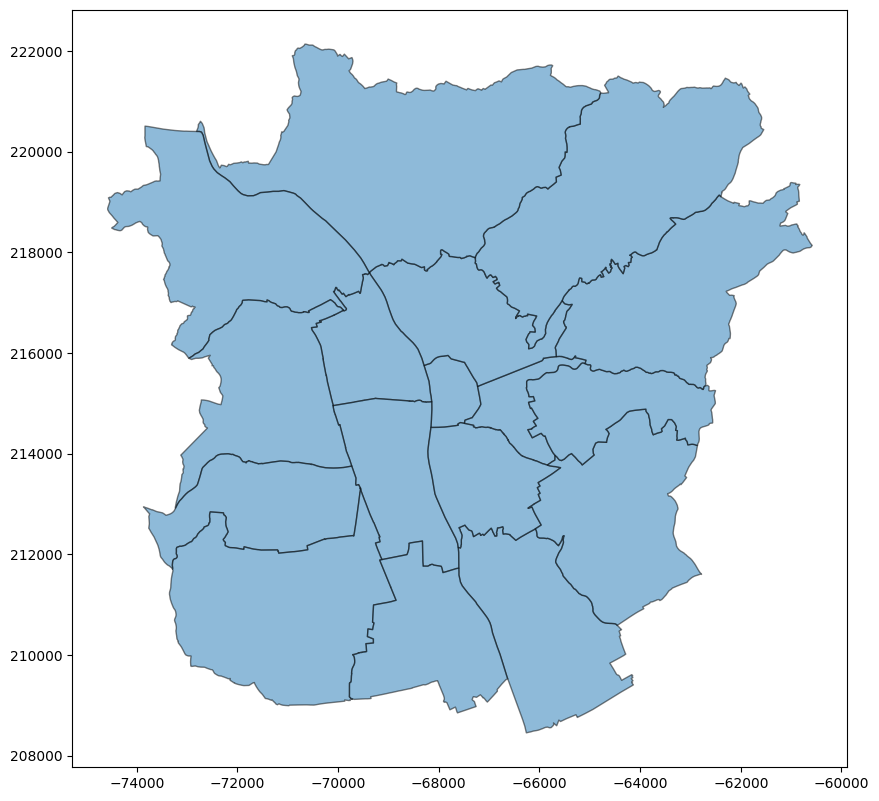

In [ ]:
# Get districts of Graz
# Layout 0
gdf_districts = ox.features_from_place(place_name, tags={'admin_level': '9'})

# Filter to only polygons and reproject
gdf_districts = gdf_districts[gdf_districts.geometry.type.isin(['Polygon', 'MultiPolygon'])]
gdf_districts = gdf_districts.to_crs(epsg=31256)

# Drop all columns except 'name' and 'geometry'
gdf_districts = gdf_districts[['name', 'geometry']]

# plot the districts
gdf_districts.plot(figsize=(10,10), alpha=0.5, edgecolor='k')

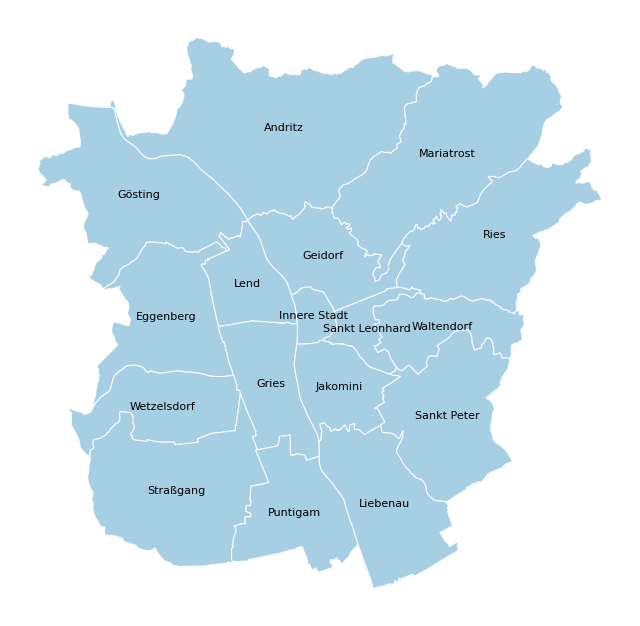

In [ ]:
# Map of all districts in Graz (Layout 1)
# Add district labels at polygon centroids
gdf_districts["centroid"] = gdf_districts.geometry.centroid

ax = gdf_districts.plot(
    figsize=(8, 10),
    edgecolor="white",
    linewidth=0.8,
    facecolor="#9ecae1",
    alpha=0.9
)
ax.set_axis_off()

for _, row in gdf_districts.iterrows():
    ax.text(
        row.centroid.x,
        row.centroid.y,
        row["name"],
        ha="center",
        va="center",
        fontsize=8
    )



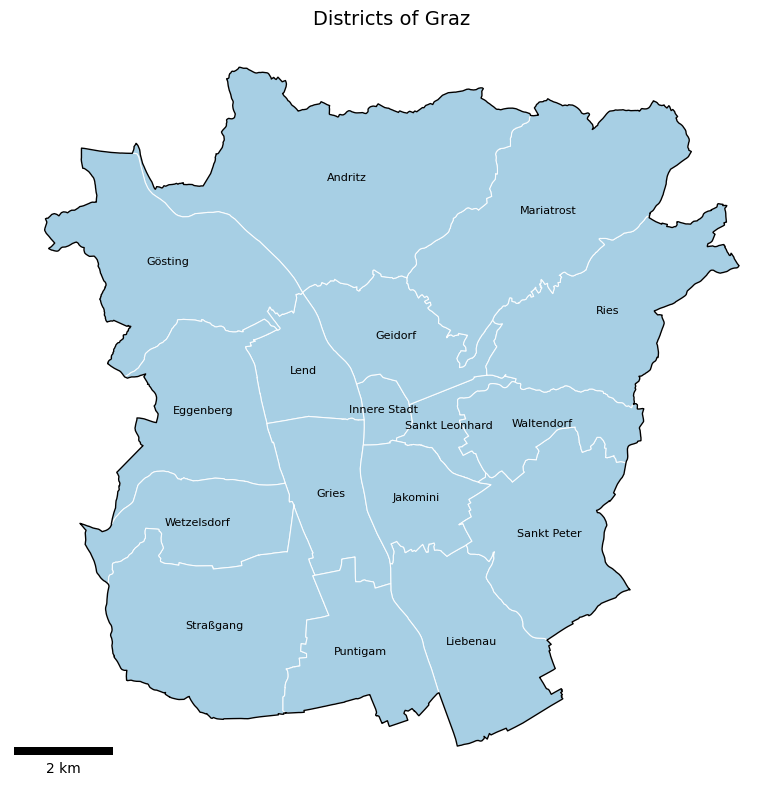

In [ ]:
# Map of all districts in Graz (Layout 2)
fig, ax = plt.subplots(figsize=(10, 8))

# Plot districts as filled polygons
gdf_districts.plot(
    ax=ax,
    facecolor="#9ecae1",   # light blue
    edgecolor="white",     # white borders between districts
    linewidth=0.8,
    alpha=0.9
)

# Draw outer city boundary in black (if you have gdf_graz)
gdf_graz.boundary.plot(ax=ax, color='black', linewidth=1.0)

# Add district labels at polygon centroids
gdf_districts["centroid"] = gdf_districts.geometry.centroid

for _, row in gdf_districts.iterrows():
    ax.text(
        row.centroid.x,
        row.centroid.y,
        row["name"],
        ha="center",
        va="center",
        fontsize=8
    )

# Title
ax.set_title("Districts of Graz", fontsize=14)

# Turn off axes
ax.axis("off")

# Scale bar in bottom-left (same style as green spaces map)
scalebar = ScaleBar(1, units='m', location='lower left', box_alpha=0.6)
ax.add_artist(scalebar)

plt.tight_layout()
plt.show()


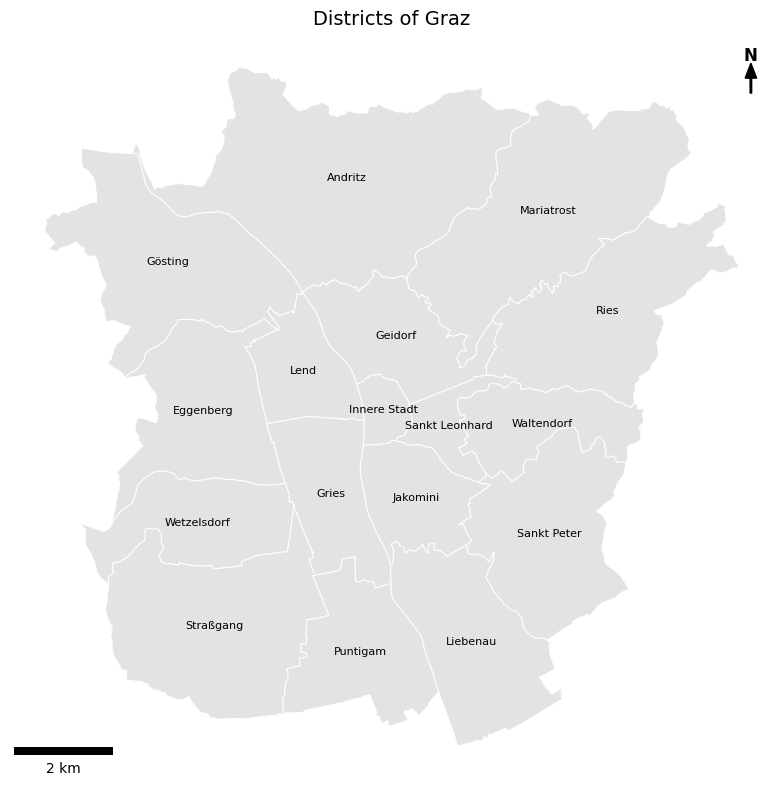

In [ ]:
# Map of all districts in Graz (Layout 3)
fig, ax = plt.subplots(figsize=(10, 8))

# Plot districts as filled polygons in a neutral color
gdf_districts.plot(
    ax=ax,
    facecolor="#e0e0e0",     # light grey 
    edgecolor="white",
    linewidth=0.8,
    alpha=0.9
)

# Add district labels at polygon centroids
gdf_districts["centroid"] = gdf_districts.geometry.centroid

for _, row in gdf_districts.iterrows():
    ax.text(
        row.centroid.x,
        row.centroid.y,
        row["name"],
        ha="center",
        va="center",
        fontsize=8
    )

# Title
ax.set_title("Districts of Graz", fontsize=14)

# Turn off axes
ax.axis("off")

# Scale bar in bottom-left (same style as green spaces map)
scalebar = ScaleBar(1, units="m", location="lower left", box_alpha=0.6)
ax.add_artist(scalebar)


# North arrow (explicit color)
ax.annotate(
    "N",
    xy=(0.97, 0.97), xycoords="axes fraction",
    ha="center", va="center",
    fontsize=12, fontweight="bold",
    color="black"
)

ax.arrow(
    0.97, 0.92,
    0, 0.04,
    transform=ax.transAxes,
    width=0.002,
    head_width=0.015,
    head_length=0.02,
    length_includes_head=True,
    color="black"
)


plt.tight_layout()
plt.show()


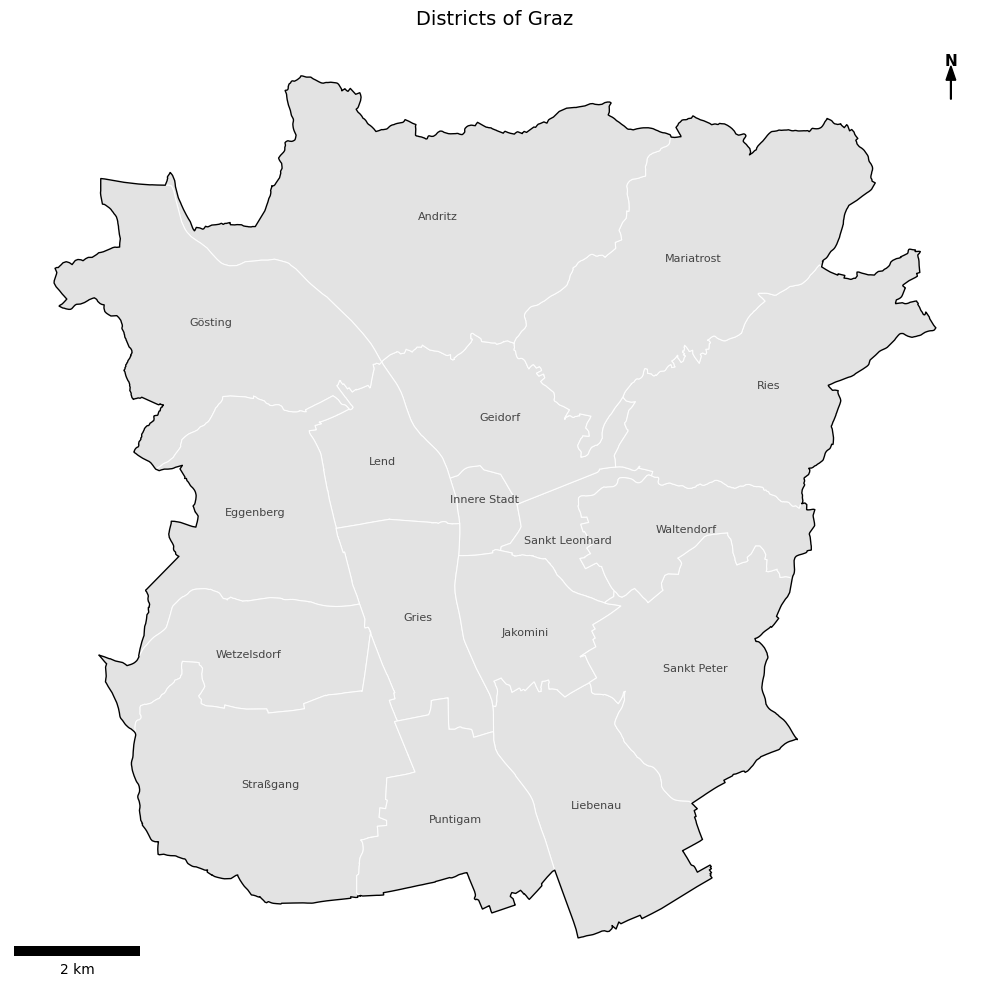

In [ ]:

# Layout 4
# Map of all districts in Graz (grey layout with labels, scale bar, north arrow)
fig, ax = plt.subplots(figsize=(10, 10))

# 1) Plot districts in light grey
gdf_districts.plot(
    ax=ax,
    facecolor="#e0e0e0",     # light grey
    edgecolor="white",
    linewidth=0.8,
    alpha=0.9,
    zorder=1
)

# 2) plot outer city boundary in black (if available)
gdf_graz.boundary.plot(
    ax=ax,
    color="black",
    linewidth=1.0,
    zorder=2
)

# 3) Pre-compute centroids for label placement
gdf_districts["centroid"] = gdf_districts.geometry.centroid

# small manual offsets for labels that overlap 
label_offsets = {
    "Innere Stadt": (0, 200),
    "Sankt Leonhard": (0, -150),
    "Jakomini": (0, -150),
    # add more if needed, e.g. "Gries": (0, -150)
}

# 4) District labels (centroids)
for _, row in gdf_districts.iterrows():
    dx, dy = label_offsets.get(row["name"], (0, 0))

    ax.text(
        row.centroid.x + dx,
        row.centroid.y + dy,
        row["name"],
        ha="center",
        va="center",
        fontsize=8,
        color="#444444",   # dark grey 
        zorder=3
    )

# 5) Title
ax.set_title("Districts of Graz", fontsize=14)

# 6) Turn off axes
ax.axis("off")

# 7) Scale bar in bottom-left
#    (CRS must be metric, e.g. EPSG:31256, which I've already checked)
scalebar = ScaleBar(
    1,
    units="m",
    location="lower left",
    box_alpha=0.6
)
ax.add_artist(scalebar)

# 8) North arrow in upper-right corner 
ax.annotate(
    "N",
    xy=(0.97, 0.97), xycoords="axes fraction",
    ha="center", va="center",
    fontsize=11, fontweight="bold",
    color="black"
)

ax.arrow(
    0.97, 0.93,          # start (x, y) in axes fraction
    0, 0.035,            # dx, dy
    transform=ax.transAxes,
    width=0.0008,        
    head_width=0.010,
    head_length=0.015,
    length_includes_head=True,
    color="black"
)

plt.tight_layout()
plt.show()


#### Population data

In [81]:
# Import population data and merge with districts
df_population = pd.read_csv("graz_bev.csv", header=0, sep=';')
gdf_bev_districts = gdf_districts.merge(df_population, left_on='name', right_on='Bezirk')
gdf_bev_districts = gdf_bev_districts.drop(columns=['Bezirk'])

#### Residential areas

In [82]:
# get residential areas of Graz
gdf_residential = ox.features_from_place(place_name, tags={"landuse": "residential"})
gdf_residential = gdf_residential.to_crs(epsg=31256)
# dissolve all residential areas into one single geometry and cut to the boundary of Graz
gdf_residential = gdf_residential.dissolve()
gdf_residential = gpd.overlay(gdf_residential, gdf_graz, how='intersection')

/Users/tarabecker/Uni/GIS_Analyse_Technique2/venv-gst200b/lib/python3.12/site-packages/geopandas/tools/overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 251 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)


#### Network of Graz

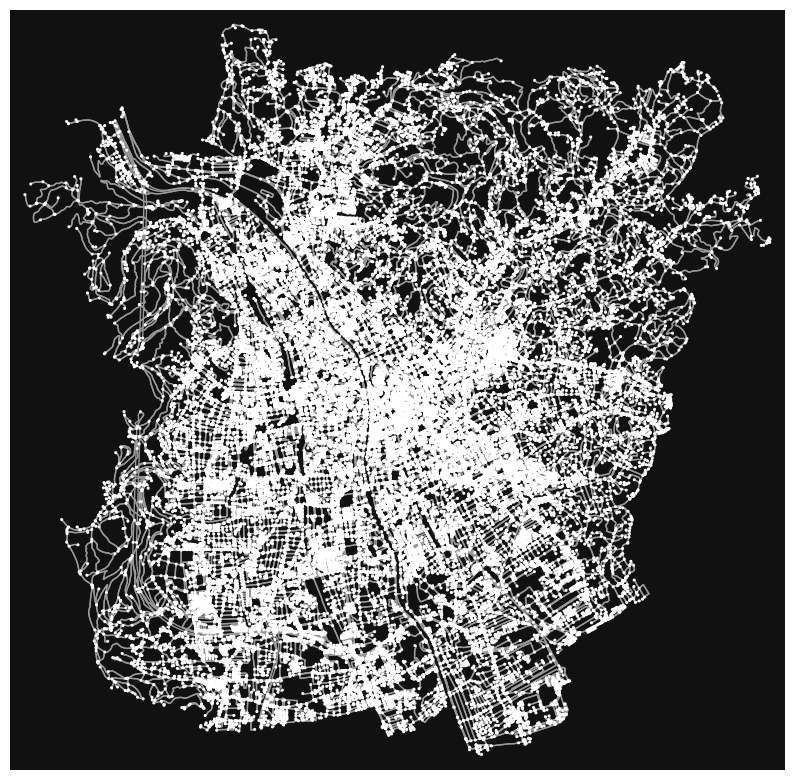

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [83]:
#if street network already exists, load it (to save time), otherwise download and save it
try:
    network_graz = ox.load_graphml("graz_street_network.graphml")
except:
    # get the street network for walking within the boundary of Graz
    network_graz = ox.graph_from_place(place_name, network_type="all")
    network_graz = ox.project_graph(network_graz, to_crs="epsg:31256")
    #save the graph
    ox.save_graphml(network_graz, filepath="graz_street_network.graphml")

# Plot the network using osmnx built-in function (Layout 0)
ox.plot_graph(network_graz, node_size=5, figsize=(10,10))

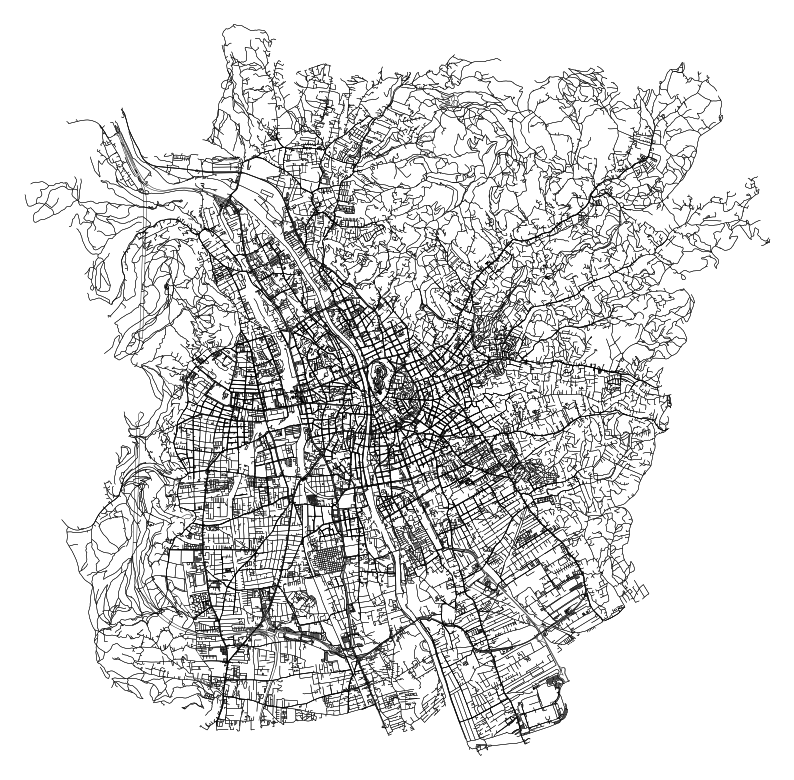

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [84]:
# Plot walking network of Graz (Layout 1)
ox.plot_graph(
    network_graz,
    figsize=(10, 10),
    bgcolor="white",
    edge_color="black",
    edge_linewidth=0.3,
    node_size=0
)

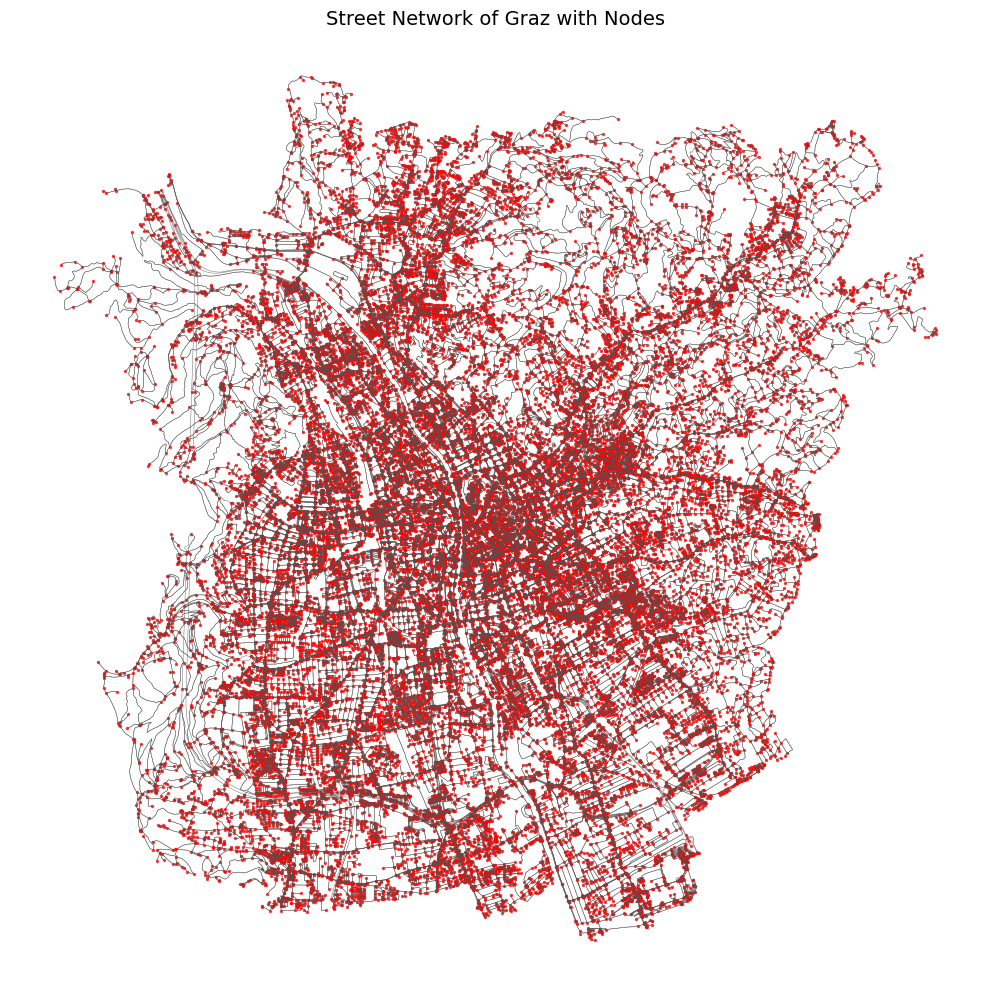

In [85]:
# Layout 2
# Convert graph to GeoDataFrames
nodes, edges = ox.graph_to_gdfs(network_graz)

fig, ax = plt.subplots(figsize=(10, 10))

# 1) All streets as background
edges.plot(
    ax=ax,
    linewidth=0.3,
    color="#555555"
)

# 2) Nodes as points
nodes.plot(
    ax=ax,
    markersize=2,        # very small
    color="red",
    alpha=0.7
)

ax.set_axis_off()
ax.set_title("Street Network of Graz with Nodes", fontsize=14)

plt.tight_layout()
plt.show()


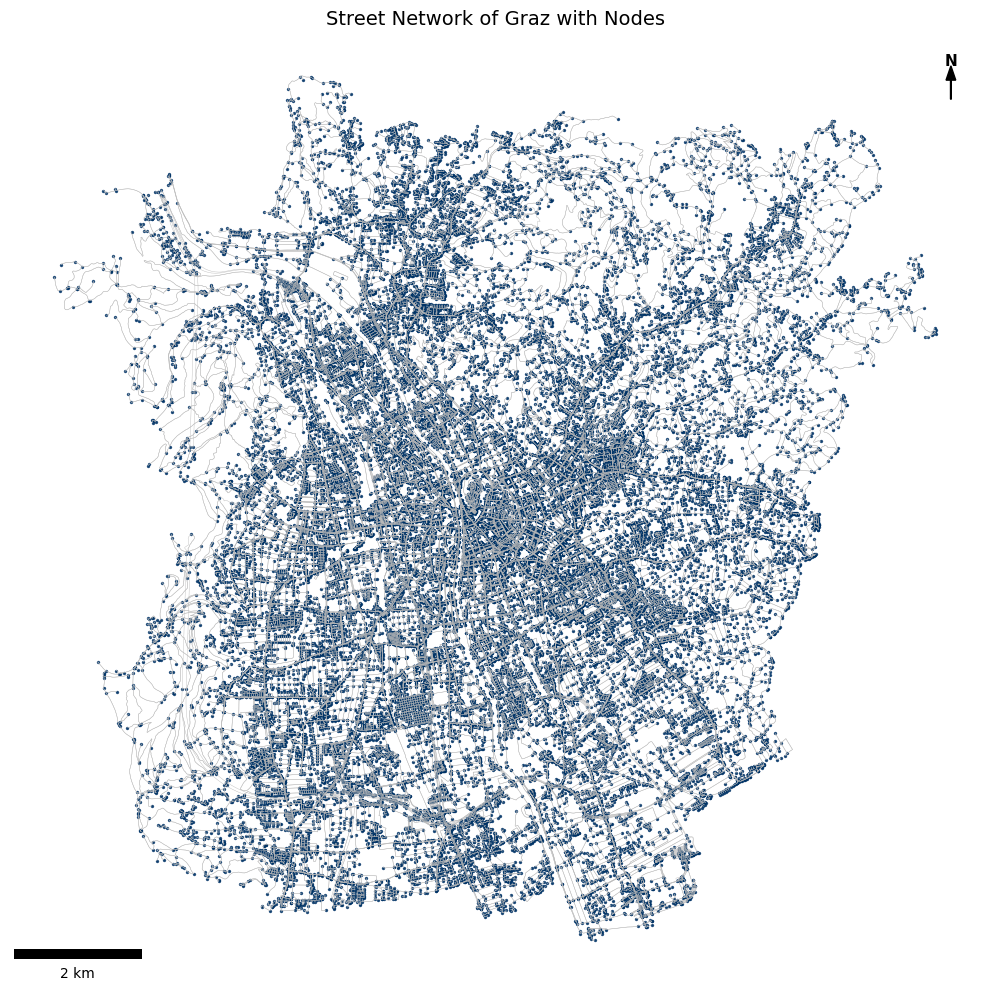

In [86]:
# Layout 3
# Street network of Graz with nodes (dark blue), scale bar and north arrow
fig, ax = plt.subplots(figsize=(10, 10))

# Plot all streets in light grey
edges.plot(
    ax=ax,
    linewidth=0.3,
    color="#bbbbbb"        # light grey for edges
)

# Plot nodes in dark blue
nodes.plot(
    ax=ax,
    markersize=2,          
    color="#003366",       # dark blue
    alpha=0.8
)

# Title
ax.set_title("Street Network of Graz with Nodes", fontsize=14)

# Turn off axes
ax.axis("off")

# Scale bar in bottom-left 
scalebar = ScaleBar(1, units="m", location="lower left", box_alpha=0.6)
ax.add_artist(scalebar)

# North arrow in upper-right corner
ax.annotate(
    "N",
    xy=(0.97, 0.97), xycoords="axes fraction",
    ha="center", va="center",
    fontsize=11, fontweight="bold",
    color="black"
)
ax.arrow(
    0.97, 0.93,          # start (x, y)
    0, 0.035,            # dx, dy
    transform=ax.transAxes,
    width=0.0008,        
    head_width=0.010,
    head_length=0.015,
    length_includes_head=True,
    color="black"
)

plt.tight_layout()
plt.show()


In [87]:
# Check if scale bar is correct
edges.crs

edges.crs


<Projected CRS: EPSG:31256>
Name: MGI / Austria GK East
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Austria east of 14°50'E of Greenwich (32°30'E of Ferro).
- bounds: (14.83, 46.56, 17.17, 49.02)
Coordinate Operation:
- name: Austria Gauss-Kruger East
- method: Transverse Mercator
Datum: Militar-Geographische Institut
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich

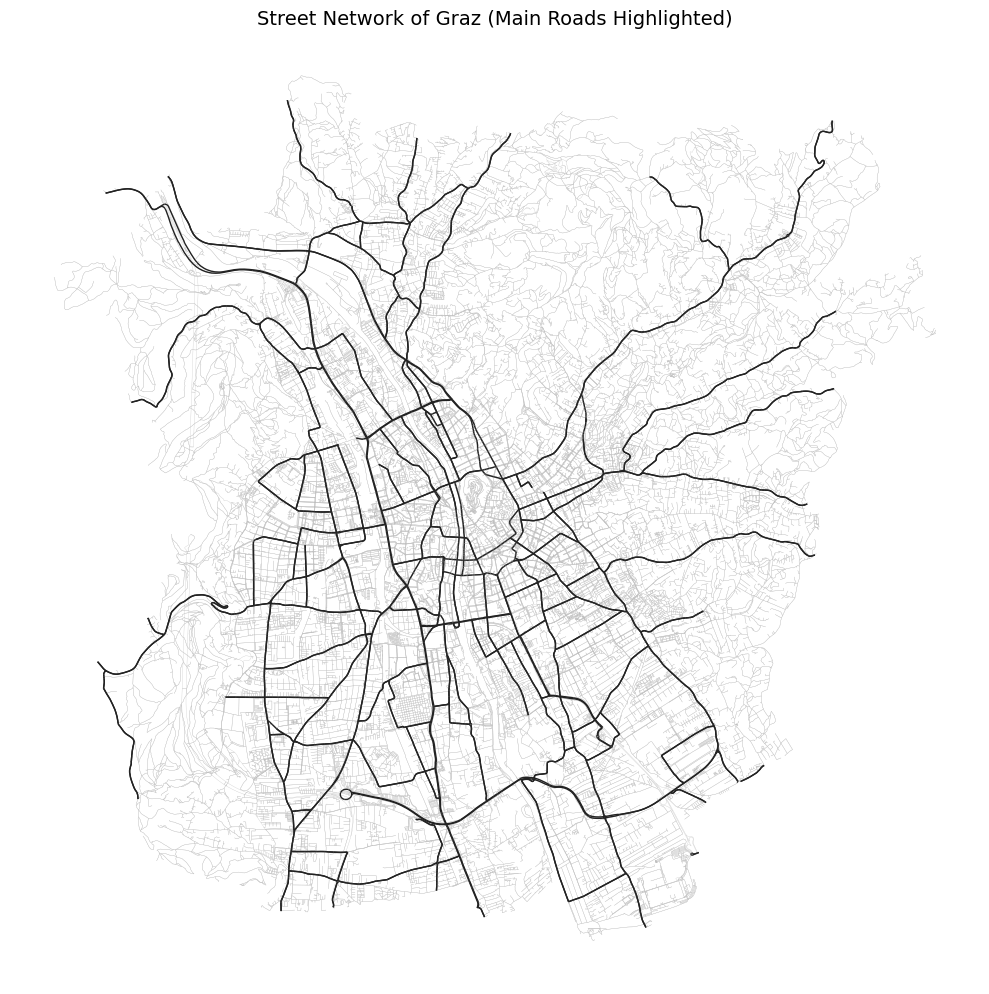

In [88]:
# Convert graph to GeoDataFrames
nodes, edges = ox.graph_to_gdfs(network_graz)

fig, ax = plt.subplots(figsize=(10, 10))

# Plot all streets in light grey
edges.plot(
    ax=ax,
    linewidth=0.2,
    color="#c0c0c0"  # light grey
)

# Select main roads 
main_roads = edges[edges["highway"].isin(
    ["primary", "secondary", "tertiary", "trunk"]
)]

# Plot main roads on top in dark
main_roads.plot(
    ax=ax,
    linewidth=1.0,
    color="#222222"
)

ax.set_axis_off()
ax.set_title("Street Network of Graz (Main Roads Highlighted)", fontsize=14)

plt.tight_layout()
plt.show()


In [89]:
# Download Autobahnen and trunks in Graz from osmnx
highways = ox.features_from_place(
    place_name,
    tags={"highway": ["motorway", "trunk"]}
)
highways = highways.to_crs(epsg=31256)
highways = highways[highways['tunnel'] != 'yes']

#create buffer of 50 meters around highways
highway_buffer = highways.buffer(50)

#highways.plot()

#### Green spaces from OSMNX

<Axes: >

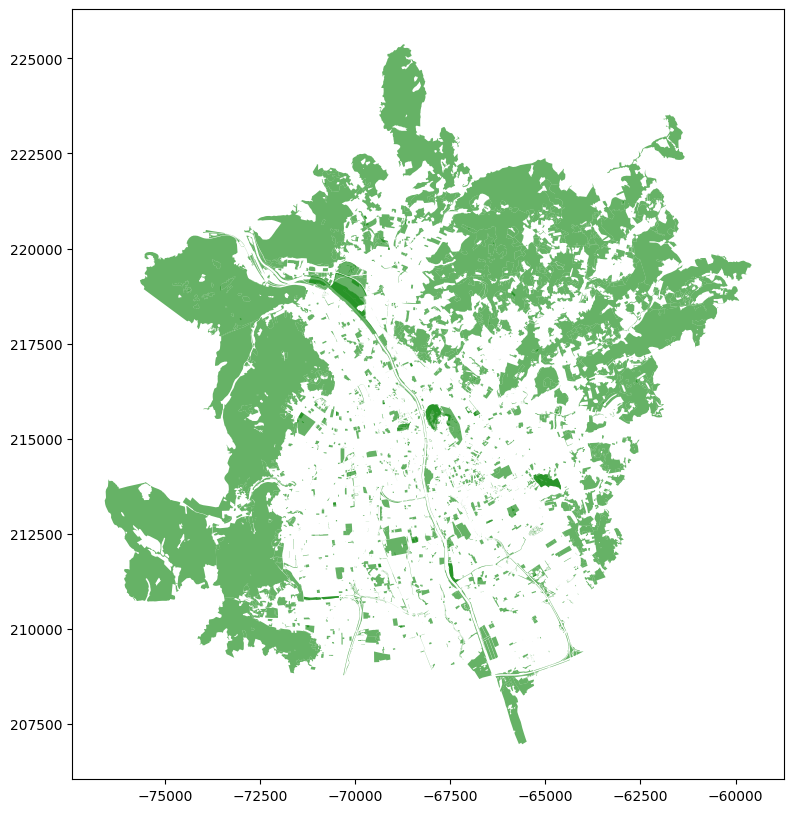

In [90]:
# Define tags for urban green spaces and parks
tags = {
    "leisure": ["park", "garden", "nature_reserve", "recreation_ground"],
    "landuse": ["forest", "grass", "meadow", "recreation_ground"]
}

tags = {
    "leisure": [
        "park",
        "garden",
        "nature_reserve",
        "recreation_ground",
        "pitch",          # often grassy sports fields
        "golf_course"
    ],
    "landuse": [
        "forest",
        "grass",
        "meadow",
        "recreation_ground",
        "allotments",
        "village_green",
        "cemetery"
    ],
    "natural": [
        "wood",
        "grassland",
        "scrub",
        "heath"
    ],
    "amenity": [
        "park",
        "playground"
        "graveyard"
    ]
}

# Download all green spaces in Graz & change the CRS
green_spaces = ox.features_from_place(place_name, tags=tags)
green_spaces = green_spaces[green_spaces.geometry.geom_type.isin(["Polygon", "MultiPolygon"])]
green_spaces = green_spaces.to_crs(epsg=31256)


# Quick visualization
green_spaces.plot(color='green', alpha=0.6, figsize=(10, 10))

# Data management

#### Exclude unsuitable green spaces

In [91]:
# Clean data
# exclude green spaces that intersect with highway buffer
green_spaces = green_spaces[~green_spaces.geometry.intersects(highway_buffer.unary_union)]

#keep only relevant columns
green_spaces = green_spaces[['geometry', 'amenity', 'leisure', 'landuse', 'natural', 'sport', 'name','access']]

/var/folders/75/03q7dtq90qq5dk9lqfpgztbh0000gp/T/ipykernel_818/677269605.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  green_spaces = green_spaces[~green_spaces.geometry.intersects(highway_buffer.unary_union)]


In [92]:
# Remove invalid green areas after visual inspection
green_spaces = green_spaces[~green_spaces['name'].isin(['Merkur Arena'])]
green_spaces = green_spaces[green_spaces['sport'].isna() | green_spaces['sport'].isin(['soccer', 'equestrian', 'golf', 'soccer; rugby', 'baseball', 'bmx', 'rugby', 'cricket', 'archery', 'baseball;cricket'])]


#### Extract public green areas

In [93]:

# Extract public-accessible green spaces (parks, urban forests, cemeteries etc.)
public_green = green_spaces[
    (green_spaces["leisure"].isin(["park", "garden", "recreation_ground"])) |
    (green_spaces["landuse"].isin(["forest", "recreation_ground", "cemetery"])) |
    (green_spaces["natural"].isin(["wood"])) |
    (green_spaces["amenity"].isin(["park", "playground", "graveyard"]))
]
# Drop private gardens without name
public_green = public_green[~((public_green["leisure"] == "garden") & (public_green["name"].isna()))]

#exclude public green spaces that are marked as 'no' or 'private' access
public_green = public_green[public_green['access'].isna() | public_green['access'].isin(['yes', 'permissive'])]

In [94]:
# Create categories for public green spaces: parks and gardens, urban forests, cemetery
# Create a new column 'category' based on conditions
def categorize_green_space(row):
    if row['leisure'] in ['park', 'garden', 'recreation_ground'] or row['landuse'] == 'recreation_ground' or row['amenity'] in ['park', 'playground']:
        return 'park_garden'
    elif row['landuse'] == 'forest' or row['natural'] == 'wood':
        return 'urban_forest'
    elif row['landuse'] == 'cemetery' or row['amenity'] == 'graveyard':
        return 'cemetery'
    else:
        return 'other' 
public_green['category'] = public_green.apply(categorize_green_space, axis=1)

In [95]:
# Exclude green spaces under 10000 m2
public_green_over_1ha = public_green[public_green.geometry.area >= 10000]
public_green_over_1ha = gpd.overlay(public_green_over_1ha, gdf_graz, how='intersection')

/Users/tarabecker/Uni/GIS_Analyse_Technique2/venv-gst200b/lib/python3.12/site-packages/geopandas/tools/overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)


In [96]:
# Visualization of public green areas, with and without green spaces <1ha
map_public = KeplerGl(height=600)

map_public.add_data(data=public_green_over_1ha, name='Green spaces over 1ha')
map_public.add_data(data=public_green, name='All public green spaces')

map_public

/Users/tarabecker/Uni/GIS_Analyse_Technique2/venv-gst200b/lib/python3.12/site-packages/jupyter_client/session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant: nan
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


/Users/tarabecker/Uni/GIS_Analyse_Technique2/venv-gst200b/lib/python3.12/site-packages/jupyter_client/session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant: nan
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(data={'Green spaces over 1ha': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 1…

#### Dissolve green space polygons

In [97]:
# Dissolve green areas by category (parks and gardens, urban forests, cemetery)
public_green_categories = public_green.dissolve(by='category', as_index=False)

# Dissolve all green areas and cut to Graz boundary
public_green_all = public_green_categories.dissolve(as_index=False)
#select only public green spaces within

edges = ox.graph_to_gdfs(network_graz, nodes=False, edges=True)

# Clip green spaces to Graz boundary
public_green_graz = gpd.clip(public_green_all, gdf_graz)

#### Get access points of parks

In [98]:
map_test = KeplerGl(height=600)
map_test.add_data(data=public_green_all, name='Public Green Spaces Graz Boundary')
map_test

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'Public Green Spaces Graz Boundary': {'index': [0], 'columns': ['index', 'geometry', 'category'…

/var/folders/75/03q7dtq90qq5dk9lqfpgztbh0000gp/T/ipykernel_818/254967105.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  park_boundaries = public_green_over_1ha.unary_union.boundary  # Get the actual geometry


Found 2440 access points


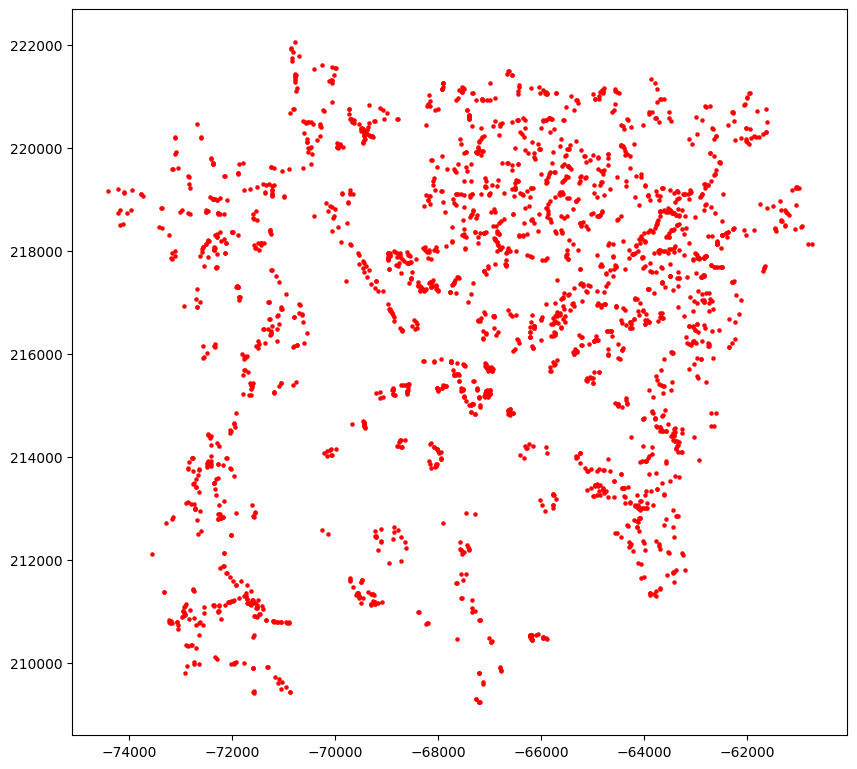

In [99]:
# Extract boundaries of parks as LineStrings
park_boundaries = public_green_over_1ha.unary_union.boundary  # Get the actual geometry

# Create a list to store access points
access_points_list = []

# Iterate through each edge and find intersections with park boundaries
for idx, edge in edges.iterrows():
    intersection = edge.geometry.intersection(park_boundaries)
    
    if not intersection.is_empty:
        if intersection.geom_type == 'Point':
            access_points_list.append(intersection)
        elif intersection.geom_type == 'MultiPoint':
            access_points_list.extend(list(intersection.geoms))
        elif intersection.geom_type == 'LineString':
            access_points_list.extend([Point(intersection.coords[0]), Point(intersection.coords[-1])
    ])

# Create GeoDataFrame of access points
access_points = gpd.GeoDataFrame(
    geometry=access_points_list,
    crs=edges.crs
)

# Remove duplicates
access_points = access_points.drop_duplicates(subset=['geometry'])

# Plot
access_points.plot(figsize=(10, 10), color='red', markersize=5)
print(f"Found {len(access_points)} access points")

In [100]:
# Visualization of access points, green spaces and street network
map_access = KeplerGl(height=600)

map_access.add_data(data=access_points, name='access points')
map_access.add_data(data=edges, name='street network')
map_access.add_data(data=public_green_over_1ha, name='public green spaces')

map_access

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


/Users/tarabecker/Uni/GIS_Analyse_Technique2/venv-gst200b/lib/python3.12/site-packages/jupyter_client/session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant: nan
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)
/Users/tarabecker/Uni/GIS_Analyse_Technique2/venv-gst200b/lib/python3.12/site-packages/jupyter_client/session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant: nan
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(data={'access points': {'index': [0, 1, 2, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 17, 18, 19, 20, 21, 22,…

# Method 1: Euclidean Distance

#### Buffer creation

In [101]:
# Create distance buffers, and more metres around the park access points
DISTS:list[int] = [300, 500, 700]  # in meters

In [102]:
graz_boundary = gdf_graz.unary_union  # Get the city boundary as a single polygon

for d in DISTS:
    # Create buffers and clip to city boundary
    access_points[f'buffer_{d}m'] = access_points.geometry.buffer(d).intersection(graz_boundary)
#create buffer for distances over 300m and convert graz boundry to polygon
graz_polygon = gpd.GeoDataFrame(geometry=[graz_boundary], crs=access_points.crs)
access_points[f'buffer_over_{DISTS[-1]}m'] = graz_polygon.difference(access_points[f'buffer_{DISTS[-1]}m'].unary_union)

/var/folders/75/03q7dtq90qq5dk9lqfpgztbh0000gp/T/ipykernel_818/3792197659.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  graz_boundary = gdf_graz.unary_union  # Get the city boundary as a single polygon
/var/folders/75/03q7dtq90qq5dk9lqfpgztbh0000gp/T/ipykernel_818/3792197659.py:8: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  access_points[f'buffer_over_{DISTS[-1]}m'] = graz_polygon.difference(access_points[f'buffer_{DISTS[-1]}m'].unary_union)


#### Dissolve buffers 

In [103]:
# Dissolve buffers
eucl_buffers = {}
#set previous buffer union to empty geometry
previous_union = gpd.GeoSeries([gpd.GeoSeries([]).unary_union], crs=access_points.crs).unary_union
#loop thorugh distances, dissolve and subtract previous buffers

for d in DISTS:
    eucl_buffers[d] = gpd.GeoDataFrame(geometry=access_points[f'buffer_{d}m']).dissolve()
    #subtract previous buffers to create rings
    eucl_buffers[d]['geometry'] = eucl_buffers[d].geometry.difference(previous_union)
    #subtract public_green_all
    eucl_buffers[d]['geometry'] = eucl_buffers[d].geometry.difference(public_green_over_1ha.unary_union)
    
    #update previous union
    previous_union = eucl_buffers[d].geometry.unary_union


# Dissolve buffer over max. DIST and subtract parks
eucl_buffers[f'over_{DISTS[-1]}m'] = gpd.GeoDataFrame(geometry=access_points[f'buffer_over_{DISTS[-1]}m'])
eucl_buffers[f'over_{DISTS[-1]}m']['geometry'] = eucl_buffers[f'over_{DISTS[-1]}m'].geometry.difference(public_green_over_1ha.unary_union)

/var/folders/75/03q7dtq90qq5dk9lqfpgztbh0000gp/T/ipykernel_818/1340368380.py:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  previous_union = gpd.GeoSeries([gpd.GeoSeries([]).unary_union], crs=access_points.crs).unary_union
/var/folders/75/03q7dtq90qq5dk9lqfpgztbh0000gp/T/ipykernel_818/1340368380.py:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  previous_union = gpd.GeoSeries([gpd.GeoSeries([]).unary_union], crs=access_points.crs).unary_union
/var/folders/75/03q7dtq90qq5dk9lqfpgztbh0000gp/T/ipykernel_818/1340368380.py:12: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  eucl_buffers[d]['geometry'] = eucl_buffers[d].geometry.difference(public_green_over_1ha.unary_union)
/var/folders/75/03q7dtq90qq5dk9lqfpgztbh0000gp/T/ipykernel_818/1340368380.py:15: DeprecationWarning: The 'unary_union' attribute is deprecated, use the

# Method 2: Network Analysis

For routing, the access points must exist as nodes in the network. For this, they need to be projected on edges and then added as nodes; the edges have to split up at the locations of the new access point nodes.

#### Project access points on edges of street network

In [104]:
print("Building spatial index...")

# Create array of edge geometries
edge_geoms = edges.geometry.values

# Build STRtree spatial index
tree = STRtree(edge_geoms)

print(f"Processing {len(access_points)} access points...")
access_point_edges = []

for idx, access_point in access_points.iterrows():
    point = access_point.geometry
    
    # Query nearest geometries using the spatial index
    # Use query with a small buffer to get candidates
    buffer_candidates = tree.query(point.buffer(100))  # 100m buffer to get candidates
    
    # If no candidates found with 100m, expand search
    if len(buffer_candidates) == 0:
        buffer_candidates = tree.query(point.buffer(500))
    
    # Find the truly closest edge among candidates
    min_distance = float('inf')
    best_edge_idx = None
    best_projection = None
    
    for candidate_idx in buffer_candidates:
        edge_geom = edge_geoms[candidate_idx]
        distance = point.distance(edge_geom)
        
        if distance < min_distance:
            min_distance = distance
            best_edge_idx = candidate_idx
            best_projection = edge_geom.interpolate(edge_geom.project(point))
    
    # If still no match found, do brute force search (shouldn't happen often)
    if best_edge_idx is None:
        distances = [point.distance(geom) for geom in edge_geoms]
        best_edge_idx = np.argmin(distances)
        min_distance = distances[best_edge_idx]
        best_projection = edge_geoms[best_edge_idx].interpolate(
            edge_geoms[best_edge_idx].project(point)
        )
    
    # Extract u and v from the MultiIndex
    edge_index = edges.index[best_edge_idx]
    u_node = edge_index[0]
    v_node = edge_index[1]
    
    # Get edge properties
    edge_geom = edge_geoms[best_edge_idx]
    edge_length = edge_geom.length
    dist_from_u = edge_geom.project(best_projection)
    
    access_point_edges.append({
        'access_point_id': idx,
        'edge_idx': best_edge_idx,
        'projected_point': best_projection,
        'distance_to_edge': min_distance,
        'u': u_node,
        'v': v_node,
        'total_edge_length': edge_length,
        'distance_from_u': dist_from_u,
    })
    
    # Progress indicator
    if (len(access_point_edges)) % 100 == 0:
        print(f"Processed {len(access_point_edges)}/{len(access_points)} access points")

# Create the DataFrame
access_edges_df = pd.DataFrame(access_point_edges)

print(f"\nProcessed {len(access_edges_df)} access points")
print(f"Max distance to nearest edge: {access_edges_df['distance_to_edge'].max():.2f}m")
print(f"Mean distance to nearest edge: {access_edges_df['distance_to_edge'].mean():.2f}m")

Building spatial index...
Processing 2440 access points...
Processed 100/2440 access points
Processed 200/2440 access points
Processed 300/2440 access points
Processed 400/2440 access points
Processed 500/2440 access points
Processed 600/2440 access points
Processed 700/2440 access points
Processed 800/2440 access points
Processed 900/2440 access points
Processed 1000/2440 access points
Processed 1100/2440 access points
Processed 1200/2440 access points
Processed 1300/2440 access points
Processed 1400/2440 access points
Processed 1500/2440 access points
Processed 1600/2440 access points
Processed 1700/2440 access points
Processed 1800/2440 access points
Processed 1900/2440 access points
Processed 2000/2440 access points
Processed 2100/2440 access points
Processed 2200/2440 access points
Processed 2300/2440 access points
Processed 2400/2440 access points

Processed 2440 access points
Max distance to nearest edge: 0.00m
Mean distance to nearest edge: 0.00m


#### Add nodes to the graph

In [105]:
print(f"Original graph: {network_graz.number_of_nodes()} nodes, {network_graz.number_of_edges()} edges")

# Add virtual nodes to the graph
G_modified = network_graz.copy()

successful_splits = 0
skipped_edges = 0

for idx, row in access_edges_df.iterrows():
    virtual_node_id = f"access_{row['access_point_id']}"
    edge_u = row['u']
    edge_v = row['v']
    
    # Check if edge exists in graph
    if not G_modified.has_edge(edge_u, edge_v):
        print(f"Warning: Edge {edge_u}->{edge_v} not in graph, skipping")
        skipped_edges += 1
        continue
    
    # Get original edge data
    edge_data = G_modified[edge_u][edge_v]
    
    if isinstance(edge_data, dict):
        # MultiGraph - get the first edge (key 0)
        if 0 in edge_data:
            original_edge = edge_data[0].copy()
        else:
            # Take the first available key
            first_key = list(edge_data.keys())[0]
            original_edge = edge_data[first_key].copy()
    else:
        original_edge = edge_data.copy()
    
    # Get distances
    total_length = original_edge.get('length', row['total_edge_length'])
    dist_from_u = row['distance_from_u']
    dist_from_v = total_length - dist_from_u
    
    # Skip if virtual node would be too close to existing nodes (< 1m)
    if dist_from_u < 1.0 or dist_from_v < 1.0:
        skipped_edges += 1
        continue
    
    # Add virtual node
    G_modified.add_node(
        virtual_node_id,
        x=row['projected_point'].x,
        y=row['projected_point'].y
    )
    
    # Remove original edge (all keys if MultiGraph)
    G_modified.remove_edge(edge_u, edge_v)
    
    # Filter edge attributes to only include string keys
    edge_attrs = {
        k: v for k, v in original_edge.items() 
        if isinstance(k, str) and k != 'length'
    }
    
    # Add two new edges (split at access point)
    # Edge from u to virtual node
    G_modified.add_edge(
        edge_u, 
        virtual_node_id,
        length=dist_from_u,
        **edge_attrs
    )
    
    # Edge from virtual node to v
    G_modified.add_edge(
        virtual_node_id, 
        edge_v,
        length=dist_from_v,
        **edge_attrs
    )
    
    successful_splits += 1
    
    # Progress indicator
    if (idx + 1) % 100 == 0:
        print(f"Processed {idx + 1}/{len(access_edges_df)} edges")

print(f"\nModified graph: {G_modified.number_of_nodes()} nodes, {G_modified.number_of_edges()} edges")
print(f"Successfully split {successful_splits} edges")
print(f"Skipped {skipped_edges} edges")
print(f"Added {successful_splits} virtual access point nodes")

Original graph: 58259 nodes, 153276 edges
Processed 100/2440 edges
Processed 300/2440 edges
Processed 400/2440 edges
Processed 500/2440 edges
Processed 600/2440 edges
Processed 700/2440 edges
Processed 800/2440 edges
Processed 1000/2440 edges
Processed 1100/2440 edges
Processed 1200/2440 edges
Processed 1300/2440 edges
Processed 1400/2440 edges
Processed 1500/2440 edges
Processed 1600/2440 edges
Processed 1800/2440 edges
Processed 1900/2440 edges
Processed 2000/2440 edges
Processed 2200/2440 edges
Processed 2400/2440 edges

Modified graph: 60156 nodes, 155173 edges
Successfully split 1897 edges
Skipped 543 edges
Added 1897 virtual access point nodes


In [106]:
# Visualize modified network and access points for checking

nodes_mod = ox.graph_to_gdfs(G_modified, nodes=True, edges=False)
edges_mod = ox.graph_to_gdfs(G_modified, nodes=False, edges=True)

map3 = KeplerGl(height=600)

map3.add_data(data=access_points, name='access points')
map3.add_data(data=edges_mod, name='edges')
map3.add_data(data=nodes_mod, name='nodes')

map3

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


/Users/tarabecker/Uni/GIS_Analyse_Technique2/venv-gst200b/lib/python3.12/site-packages/jupyter_client/session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant: nan
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)
/Users/tarabecker/Uni/GIS_Analyse_Technique2/venv-gst200b/lib/python3.12/site-packages/jupyter_client/session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant: nan
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(data={'access points': {'index': [0, 1, 2, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 17, 18, 19, 20, 21, 22,…

In [107]:
# Calculate nearest node in the network for each access point (so points that were skipped because of restrictions in length of edge also get a node)
access_nodes = ox.distance.nearest_nodes(G_modified, access_points.geometry.x, access_points.geometry.y)

access_nodes = list(access_nodes)

#### Dijkstra's one-to-all routing between access points and all nodes within 300m walking distance

In [108]:
results = {}  
distance = max(DISTS)
lengths = nx.multi_source_dijkstra_path_length(
    G_modified,
    sources=access_nodes,
    cutoff=distance,
    weight='length',  # edge attribute
)
# lengths: {node: distance_to_nearest_access_node}
for node, dist in lengths.items():
    results[node] = dist

#### Join nodes with the distance information from the routing

In [109]:
dist_df = pd.DataFrame(list(results.items()), 
                      columns=['node_id', 'access_dist'])
dist_df.set_index('node_id', inplace=True)

nodes_distance = pd.merge(nodes_mod, dist_df, 
                     left_index=True, right_index=True, how='left')


In [110]:
# All nodes that are not reachable <max. DISTS are given the value inf
nodes_distance['access_dist'] = nodes_distance['access_dist'].fillna(9999)
#Set access distance of nodes that intersect public green spaces to 0
nodes_distance.loc[nodes_distance.geometry.intersects(public_green_over_1ha.unary_union), 'access_dist'] = 0


/var/folders/75/03q7dtq90qq5dk9lqfpgztbh0000gp/T/ipykernel_818/2199213112.py:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  nodes_distance.loc[nodes_distance.geometry.intersects(public_green_over_1ha.unary_union), 'access_dist'] = 0


In [111]:
#convert acess distance to float
#nodes_distance['access_dist'] = nodes_distance['access_dist'].astype(float)
nodes_distance['access_dist'] 


osmid
20824331       9999.000000
35126490       9999.000000
20824406        223.471631
1450590079      158.624837
35127847        268.686620
                  ...     
access_4837       0.000000
access_4851       0.000000
access_4852       0.000000
access_4861       0.000000
access_4863       0.000000
Name: access_dist, Length: 60156, dtype: float64

In [112]:
# Visualize the nodes with the distances to the access points
map_distances = KeplerGl(height=600)

map_distances.add_data(data=access_points, name='access points')
map_distances.add_data(data=public_green_over_1ha, name='public green spaces')
map_distances.add_data(data=nodes_distance, name='nodes')


map_distances

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


/Users/tarabecker/Uni/GIS_Analyse_Technique2/venv-gst200b/lib/python3.12/site-packages/jupyter_client/session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant: nan
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)
/Users/tarabecker/Uni/GIS_Analyse_Technique2/venv-gst200b/lib/python3.12/site-packages/jupyter_client/session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant: nan
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(data={'access points': {'index': [0, 1, 2, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 17, 18, 19, 20, 21, 22,…

#### Calculate accessibility grid

In [113]:

from scipy.interpolate import griddata
from shapely.geometry import Point, Polygon
from shapely.ops import unary_union


# Use Graz boundary to define the grid extent
minx, miny, maxx, maxy = gdf_graz.total_bounds

# Create a grid covering all of Graz
resolution = 50  # grid cell resolution
x_coords = np.arange(minx, maxx, resolution)
y_coords = np.arange(miny, maxy, resolution)
xx, yy = np.meshgrid(x_coords, y_coords)

# Get node coordinates and distances
node_points = np.array([[p.x, p.y] for p in nodes_distance.geometry])
node_distances = nodes_distance['access_dist'].values


print("Interpolating distances across grid using nearest neighbor...")
# Use 'nearest' method instead of 'linear' to fill all areas
grid_distances = griddata(
    node_points, 
    node_distances, 
    (xx, yy), 
    method='nearest'  # Changed from 'linear' to 'nearest'
)

# Distance band definitions
distance_bands = [
    (0, DISTS[0], f'0-{DISTS[0]}m', "#d7e75f"),
    (DISTS[0], DISTS[1], f'{DISTS[0]}-{DISTS[1]}m', "#c27801"),
    (DISTS[1], DISTS[2], f'{DISTS[1]}-{DISTS[2]}m', "#e93d2a"),
    (DISTS[2], 9999, f'>{DISTS[2]}m', "#c6cece")
]

# Create grid cells as polygons - only those within Graz
print("Creating grid cells...")
grid_polygons = []

# Get the Graz polygon for intersection checks
graz_geom = gdf_graz.geometry.iloc[0]

for i in range(len(x_coords) - 1):
    for j in range(len(y_coords) - 1):
        # Create cell polygon
        cell = Polygon([
            (x_coords[i], y_coords[j]),
            (x_coords[i+1], y_coords[j]),
            (x_coords[i+1], y_coords[j+1]),
            (x_coords[i], y_coords[j+1])
        ])
        
        # Only keep cells that intersect Graz
        if not graz_geom.intersects(cell):
            continue
        
        # Clip cell to Graz boundary
        clipped_cell = cell.intersection(graz_geom)
        
        # Skip if intersection is empty or too small
        if clipped_cell.is_empty or clipped_cell.area < 1:
            continue
        
        # Get distance value for this cell
        dist_value = grid_distances[j, i]

        # Handle special 9999 value first
        if dist_value == 9999:
            grid_polygons.append({
                'distance': dist_value,
                'category': f'>{DISTS[2]}m',
                'color': '#95a5a6',
                'geometry': clipped_cell
            })
            continue

        # Categorize finite distances
        categorized = False
        for min_d, max_d, label, color in distance_bands:
            if min_d <= dist_value < max_d:
                grid_polygons.append({
                    'distance': dist_value,
                    'category': label,
                    'color': color,
                    'geometry': clipped_cell
                })
                categorized = True
                break

        # Safety net for any uncategorized values (should not trigger)
        if not categorized:
            print(f"Warning: Uncategorized distance {dist_value} at cell ({i},{j})")
            grid_polygons.append({
                'distance': dist_value,
                'category': f'>{DISTS[2]}m',
                'color': '#95a5a6',
                'geometry': clipped_cell
                })


grid_gdf = gpd.GeoDataFrame(grid_polygons, crs=nodes_mod.crs)

print(f"Created {len(grid_gdf)} grid cells within Graz")

# Dissolve into zones
print("Creating accessibility zones...")
zones = []

for min_d, max_d, label, color in distance_bands:
    cells_in_zone = grid_gdf[grid_gdf['category'] == label]
    
    if len(cells_in_zone) > 0:
        merged = unary_union(cells_in_zone.geometry.values)
        area_km2 = merged.area / 1000000
        
        zones.append({
            'category': label,
            'min_distance': min_d,
            'max_distance': max_d,
            'color': color,
            'geometry': merged,
            'area_km2': area_km2
        })

zones_gdf = gpd.GeoDataFrame(zones, crs=nodes_mod.crs)



Interpolating distances across grid using nearest neighbor...
Creating grid cells...
Created 51827 grid cells within Graz
Creating accessibility zones...


In [114]:
# Visualize accessibility map
map_zones = KeplerGl(height=800)

map_zones.add_data(data=zones_gdf, name='Accessibility Zones')
map_zones.add_data(data=public_green_graz, name='Green Spaces')
map_zones.add_data(data=gdf_graz, name='graz')

map_zones

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'Accessibility Zones': {'index': [0, 1, 2, 3], 'columns': ['category', 'min_distance', 'max_dis…

### General greenness in Graz

<Axes: >

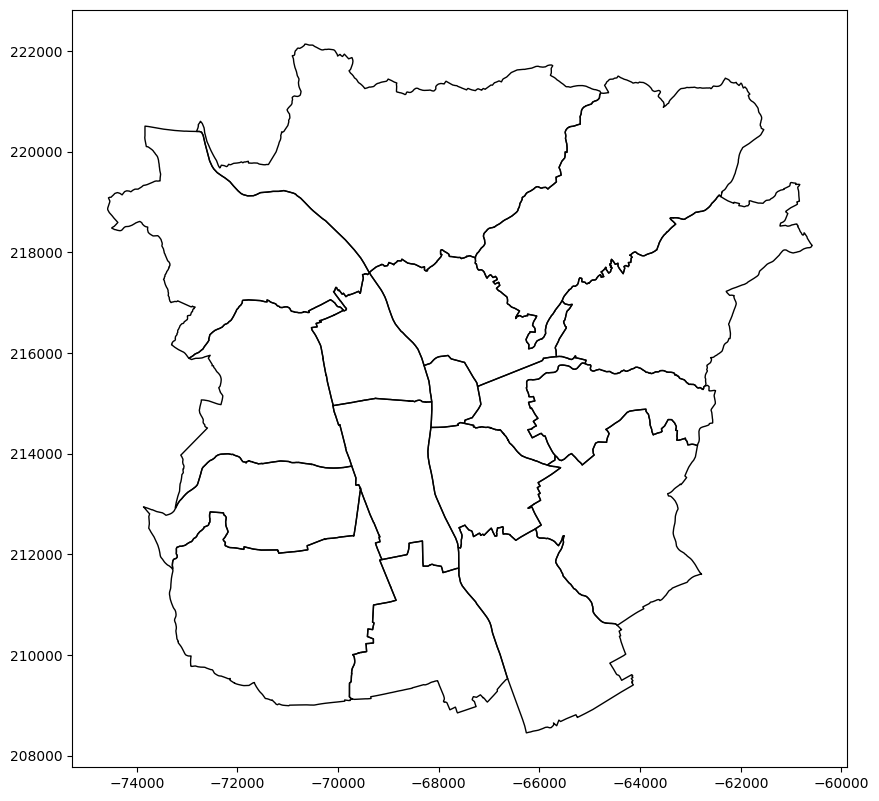

In [115]:

#plot kde and districts of Graz
fig, ax = plt.subplots(figsize=(10, 10))

gdf_districts.plot(
    ax=ax,
    facecolor="none",     # no fill
    edgecolor="black",    # boundary lines
    linewidth=1,
    zorder=1
)



# Results

## Areal statistics

#### Green space accessibility in residential areas

In [116]:
# Intersect buffers with residential areas
eucl_dist_res = {}
for key, value in eucl_buffers.items():
    eucl_dist_res[key] = gpd.overlay(value, gdf_residential, how='intersection')

# Calculate area and percentage of green residential areas by subtractig outer buffer from residential areas
green_areas_eucl = gpd.overlay(gdf_residential, eucl_buffers[f'over_{DISTS[-1]}m'], how='difference')
percent_green_eucl = (green_areas_eucl.geometry.area.sum() / gdf_residential.geometry.area.sum()) * 100
print(f"Percentage of residential areas within {DISTS[-1]}m of green space: {percent_green_eucl:.2f}%")


# Calculate deficient area (not within 300 m of green space) in total 
deficient_area_eucl = gpd.overlay(gdf_residential, eucl_buffers[f'over_{DISTS[-1]}m'], how='intersection')
percent_deficient_eucl = (deficient_area_eucl.geometry.area.sum() / gdf_residential.geometry.area.sum()) * 100
print(f"Percentage of residential areas not within {DISTS[-1]}m of green space: {percent_deficient_eucl:.2f}%")

/Users/tarabecker/Uni/GIS_Analyse_Technique2/venv-gst200b/lib/python3.12/site-packages/geopandas/tools/overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 267 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)
/Users/tarabecker/Uni/GIS_Analyse_Technique2/venv-gst200b/lib/python3.12/site-packages/geopandas/tools/overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 370 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)


Percentage of residential areas within 700m of green space: 90.52%
Percentage of residential areas not within 700m of green space: 9.48%


In [117]:
# How much of residential areas are within each buffer?
buffer_res_eucl = {}
buffer_res_eucl_area = {}
for key, value in eucl_buffers.items():
    buffer_res_eucl[key] = gpd.overlay(value, gdf_residential, how='intersection')
    buffer_res_eucl_area[key] = buffer_res_eucl[key].geometry.area.sum()/gdf_residential.geometry.area.sum() * 100
    # Print percentual areas
    print(f"Percentage of residential areas within {key}m of green space: {buffer_res_eucl_area[key]:.2f}%")

/Users/tarabecker/Uni/GIS_Analyse_Technique2/venv-gst200b/lib/python3.12/site-packages/geopandas/tools/overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 267 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)


Percentage of residential areas within 300m of green space: 56.11%
Percentage of residential areas within 500m of green space: 21.62%
Percentage of residential areas within 700m of green space: 68.54%
Percentage of residential areas within over_700mm of green space: 9.48%


/Users/tarabecker/Uni/GIS_Analyse_Technique2/venv-gst200b/lib/python3.12/site-packages/geopandas/tools/overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 370 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)


#### Deficient area percentage for each district (Euclidean buffers)

/Users/tarabecker/Uni/GIS_Analyse_Technique2/venv-gst200b/lib/python3.12/site-packages/geopandas/tools/overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 13 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)
/Users/tarabecker/Uni/GIS_Analyse_Technique2/venv-gst200b/lib/python3.12/site-packages/geopandas/tools/overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 6 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)
/Users/tarabecker/Uni/GIS_Analyse_Technique2/venv-gst200b/lib/python3.12/site-packages/geopandas/tools/overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 5 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` 

District: Innere Stadt, Percentage of residential areas not within 700m of green space: 0.00%
District: Liebenau, Percentage of residential areas not within 700m of green space: 41.76%
District: Sankt Leonhard, Percentage of residential areas not within 700m of green space: 0.00%
District: Geidorf, Percentage of residential areas not within 700m of green space: 0.00%
District: Lend, Percentage of residential areas not within 700m of green space: 13.02%
District: Gries, Percentage of residential areas not within 700m of green space: 6.99%
District: Jakomini, Percentage of residential areas not within 700m of green space: 5.06%
District: Sankt Peter, Percentage of residential areas not within 700m of green space: 9.07%
District: Waltendorf, Percentage of residential areas not within 700m of green space: 1.86%
District: Ries, Percentage of residential areas not within 700m of green space: 0.00%
District: Mariatrost, Percentage of residential areas not within 700m of green space: 0.00%
Dis

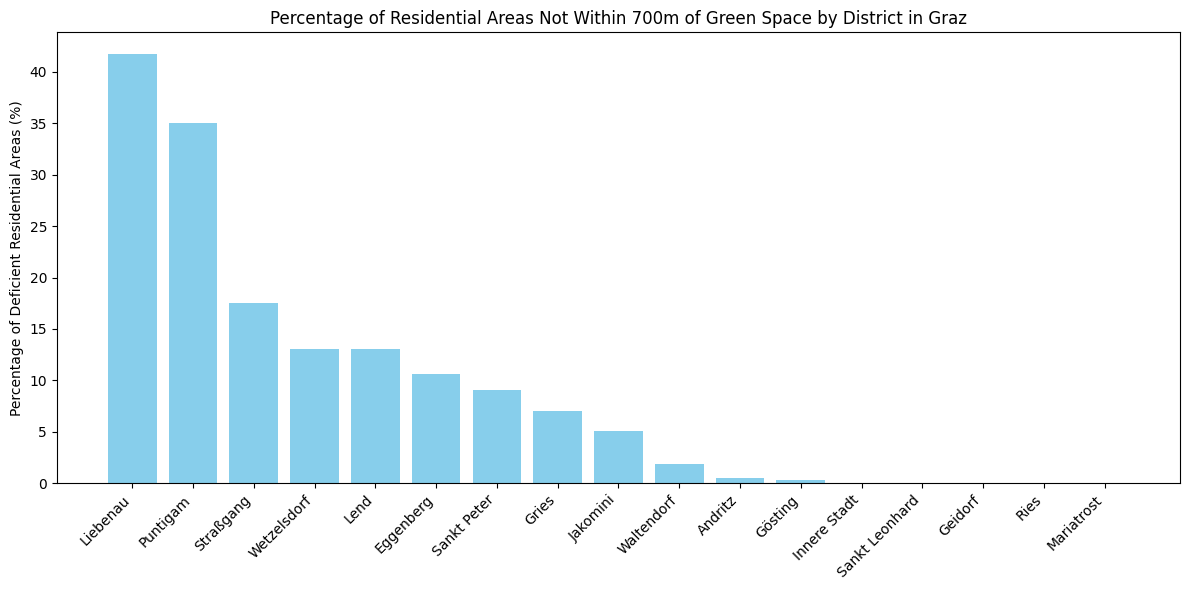

In [118]:
# Calculate deficient areas for each district
deficient_areas_districts = {}
for district in gdf_districts['name']:
    district_geom = gdf_districts[gdf_districts['name'] == district].geometry.union_all()
    residential_in_district = gpd.overlay(gdf_residential, gpd.GeoDataFrame(geometry=[district_geom], crs=gdf_residential.crs), how='intersection')
    deficient_area_district = gpd.overlay(residential_in_district, eucl_buffers[f'over_{DISTS[-1]}m'], how='intersection')
    percent_deficient_district = (deficient_area_district.geometry.area.sum() / residential_in_district.geometry.area.sum()) * 100
    deficient_areas_districts[district] = percent_deficient_district

# Print results and create bar chart
for district, percent_deficient_district in deficient_areas_districts.items():
    print(f"District: {district}, Percentage of residential areas not within {DISTS[-1]}m of green space: {percent_deficient_district:.2f}%")

# Create bar chart sorted by percentage
deficient_areas_districts_sorted = dict(sorted(deficient_areas_districts.items(), key=lambda item: item[1], reverse=True))
plt.figure(figsize=(12, 6))
plt.bar(deficient_areas_districts_sorted.keys(), deficient_areas_districts_sorted.values(), color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Percentage of Deficient Residential Areas (%)')
plt.title(f'Percentage of Residential Areas Not Within {DISTS[-1]}m of Green Space by District in Graz')
plt.tight_layout()
plt.show()

#### Deficient area percentage for each district (Walking distance)

/Users/tarabecker/Uni/GIS_Analyse_Technique2/venv-gst200b/lib/python3.12/site-packages/geopandas/tools/overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 13 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)
/Users/tarabecker/Uni/GIS_Analyse_Technique2/venv-gst200b/lib/python3.12/site-packages/geopandas/tools/overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 6 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)
/Users/tarabecker/Uni/GIS_Analyse_Technique2/venv-gst200b/lib/python3.12/site-packages/geopandas/tools/overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 5 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` 

District: Innere Stadt, % residential >700m network distance: 0.00%
District: Liebenau, % residential >700m network distance: 65.83%
District: Sankt Leonhard, % residential >700m network distance: 1.04%
District: Geidorf, % residential >700m network distance: 3.03%
District: Lend, % residential >700m network distance: 40.80%
District: Gries, % residential >700m network distance: 21.65%
District: Jakomini, % residential >700m network distance: 31.26%
District: Sankt Peter, % residential >700m network distance: 20.35%
District: Waltendorf, % residential >700m network distance: 28.22%
District: Ries, % residential >700m network distance: 0.00%
District: Mariatrost, % residential >700m network distance: 1.40%
District: Andritz, % residential >700m network distance: 17.13%
District: Gösting, % residential >700m network distance: 22.51%
District: Eggenberg, % residential >700m network distance: 35.14%
District: Wetzelsdorf, % residential >700m network distance: 42.47%
District: Straßgang, % 

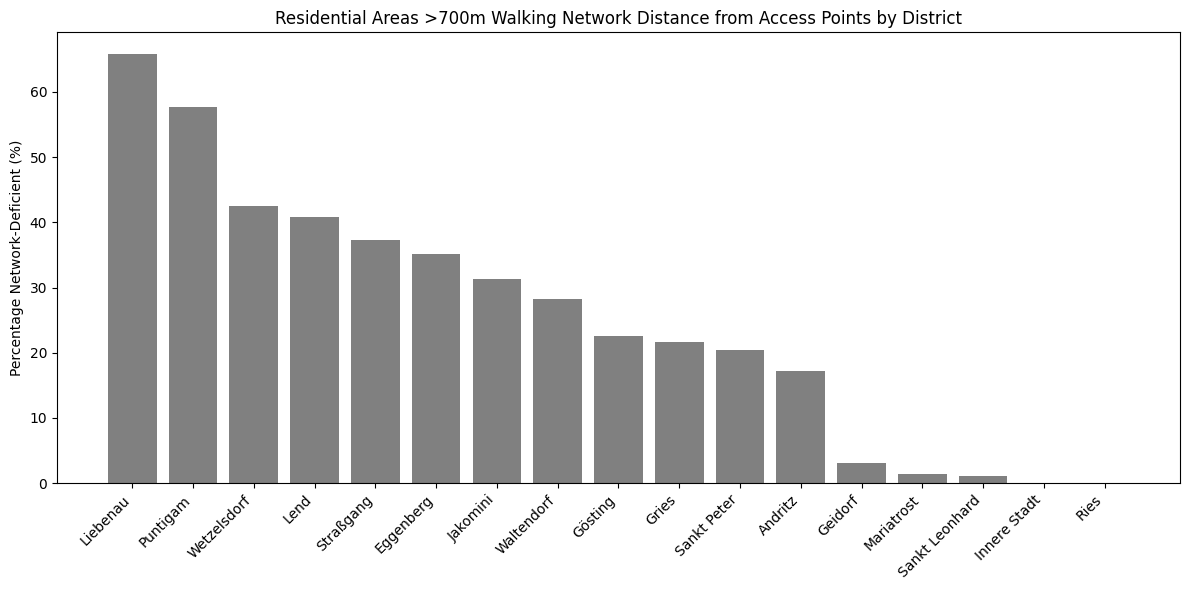

In [119]:
# Calculate network-deficient residential areas per district (>700m walking distance)
network_deficient_areas_districts = {}
network_max_distance = DISTS[-1]  # 700m

for district in gdf_districts['name']:
    district_geom = gdf_districts[gdf_districts['name'] == district].geometry.union_all()
    
    # Residential areas within this district
    residential_in_district = gpd.overlay(gdf_residential, 
                                        gpd.GeoDataFrame(geometry=[district_geom], crs=gdf_residential.crs), 
                                        how='intersection')
    
    if len(residential_in_district) == 0:
        network_deficient_areas_districts[district] = 0.0
        continue
    
    # Network-deficient: residential in >700m network distance zone (gray category)
    network_deficient_zone = zones_gdf[zones_gdf['category'] == f'>{network_max_distance}m'].geometry.union_all()
    network_deficient_overlay = gpd.overlay(residential_in_district, 
                                          gpd.GeoDataFrame(geometry=[network_deficient_zone], crs=zones_gdf.crs), 
                                          how='intersection')
    
    total_residential_area = residential_in_district.geometry.area.sum()
    network_deficient_area = network_deficient_overlay.geometry.area.sum()
    
    percent_network_deficient = (network_deficient_area / total_residential_area) * 100
    network_deficient_areas_districts[district] = percent_network_deficient

# Print network results
for district, percent in network_deficient_areas_districts.items():
    print(f"District: {district}, % residential >{network_max_distance}m network distance: {percent:.2f}%")


# Bar chart for network distances
network_deficient_sorted = dict(sorted(network_deficient_areas_districts.items(), key=lambda x: x[1], reverse=True))
plt.figure(figsize=(12, 6))
plt.bar(network_deficient_sorted.keys(), network_deficient_sorted.values(), color='gray')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Percentage Network-Deficient (%)')
plt.title(f'Residential Areas >{DISTS[-1]}m Walking Network Distance from Access Points by District')
plt.tight_layout()
plt.show()

#### Population within each buffer

In [120]:
# Population within each distance?
## intersect districts with buffers and sum population
population_within_buffers = {}
for key, value in eucl_buffers.items():
    intersected = gpd.overlay(gdf_bev_districts, value, how='intersection')
    intersected['area'] = intersected.geometry.area
    intersected['population_within_buffer'] = (intersected['area'] / gdf_bev_districts.set_index('name').loc[intersected['name'], 'geometry'].area.values) * gdf_bev_districts.set_index('name').loc[intersected['name'], 'EW'].values
    total_population = intersected['population_within_buffer'].sum()
    population_within_buffers[key] = total_population
    print(f"Population within {key}m of green space: {total_population:.0f}, ({(total_population / gdf_bev_districts['EW'].sum()) * 100:.2f}%)")

/Users/tarabecker/Uni/GIS_Analyse_Technique2/venv-gst200b/lib/python3.12/site-packages/geopandas/tools/overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 100 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)


Population within 300m of green space: 101718, (38.90%)
Population within 500m of green space: 55165, (21.10%)
Population within 700m of green space: 136375, (52.16%)
Population within over_700mm of green space: 26892, (10.29%)


/Users/tarabecker/Uni/GIS_Analyse_Technique2/venv-gst200b/lib/python3.12/site-packages/geopandas/tools/overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 105 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)


#### General "greenness": public and non-public

In [121]:
print("=" * 60)
print("GREEN SPACE ANALYSIS - GRAZ")
print("=" * 60)

# Clip green spaces to Graz boundary and dissolve to one polygon
green_spaces_graz = green_spaces.dissolve()
green_spaces_graz = gpd.clip(green_spaces, gdf_graz)

# 1. Calculate total green area in Graz
total_graz_area = gdf_graz.geometry.area.sum() / 1000000  # km²
total_green_area = green_spaces.geometry.area.sum() / 1000000  # km²
green_percentage_graz = (total_green_area / total_graz_area) * 100

print(f"\nGRAZ OVERALL:")
print(f"  Total area:        {total_graz_area:.2f} km²")
print(f"  Green space area:  {total_green_area:.2f} km²")
print(f"  Green percentage:  {green_percentage_graz:.1f}%")

# 2. Calculate green area per district
print(f"\n{'DISTRICT':<30} {'AREA (km²)':>12} {'GREEN (km²)':>12} {'GREEN %':>10}")
print("-" * 60)

district_stats = []

for idx, district in gdf_districts.iterrows():
    district_name = district.get('name', f'District {idx}')  # Adjust column name if needed
    district_geom = district.geometry
    district_area = district_geom.area / 1000000  # km²
    
    # Find green spaces within this district
    green_in_district = gpd.clip(green_spaces, gpd.GeoSeries([district_geom], crs=gdf_districts.crs))
    
    if len(green_in_district) > 0:
        green_area = green_in_district.geometry.area.sum() / 1000000  # km²
    else:
        green_area = 0
    
    green_percentage = (green_area / district_area * 100) if district_area > 0 else 0
    
    district_stats.append({
        'district': district_name,
        'district_area_km2': district_area,
        'green_area_km2': green_area,
        'green_percentage': green_percentage
    })
    
    print(f"{district_name:<30} {district_area:>12.2f} {green_area:>12.2f} {green_percentage:>9.1f}%")

# Create DataFrame with results
df_stats = pd.DataFrame(district_stats)

# Sort by green percentage
df_stats_sorted = df_stats.sort_values('green_percentage', ascending=False)

print("\n" + "=" * 60)
print("DISTRICTS RANKED BY GREEN PERCENTAGE:")
print("=" * 60)

for idx, row in df_stats_sorted.iterrows():
    print(f"{row['district']:<30} {row['green_percentage']:>6.1f}%")

GREEN SPACE ANALYSIS - GRAZ

GRAZ OVERALL:
  Total area:        127.58 km²
  Green space area:  75.50 km²
  Green percentage:  59.2%

DISTRICT                         AREA (km²)  GREEN (km²)    GREEN %
------------------------------------------------------------
Innere Stadt                           1.16         0.64      54.9%
Liebenau                               7.98         0.76       9.6%
Sankt Leonhard                         1.83         0.28      15.3%
Geidorf                                5.50         1.44      26.1%
Lend                                   3.71         0.43      11.6%
Gries                                  5.06         0.74      14.6%
Jakomini                               4.06         0.56      13.8%
Sankt Peter                            8.86         2.53      28.6%
Waltendorf                             4.48         0.85      19.0%
Ries                                  10.03         6.57      65.5%
Mariatrost                            14.11         8.83 

#### Green space accessibility (walking distances)

In [122]:
print("\n=== GREEN SPACE ACCESSIBILITY IN GRAZ ===")
total_area = zones_gdf['area_km2'].sum()
graz_total = gdf_graz.geometry.area.sum() / 1000000

print(f"Graz total area: {graz_total:.2f} km²")
print(f"Analyzed area: {total_area:.2f} km² ({total_area/graz_total*100:.1f}% of Graz)")
print()

for idx, row in zones_gdf.iterrows():
    percentage = (row['area_km2'] / total_area) * 100
    print(f"{row['category']:<15} {row['area_km2']:>8.2f} km² ({percentage:>5.1f}%)")


=== GREEN SPACE ACCESSIBILITY IN GRAZ ===
Graz total area: 127.58 km²
Analyzed area: 127.58 km² (100.0% of Graz)

0-300m             65.02 km² ( 51.0%)
300-500m           20.75 km² ( 16.3%)
500-700m           15.84 km² ( 12.4%)
>700m              25.97 km² ( 20.4%)


In [123]:
!pip install matplotlib-scalebar
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


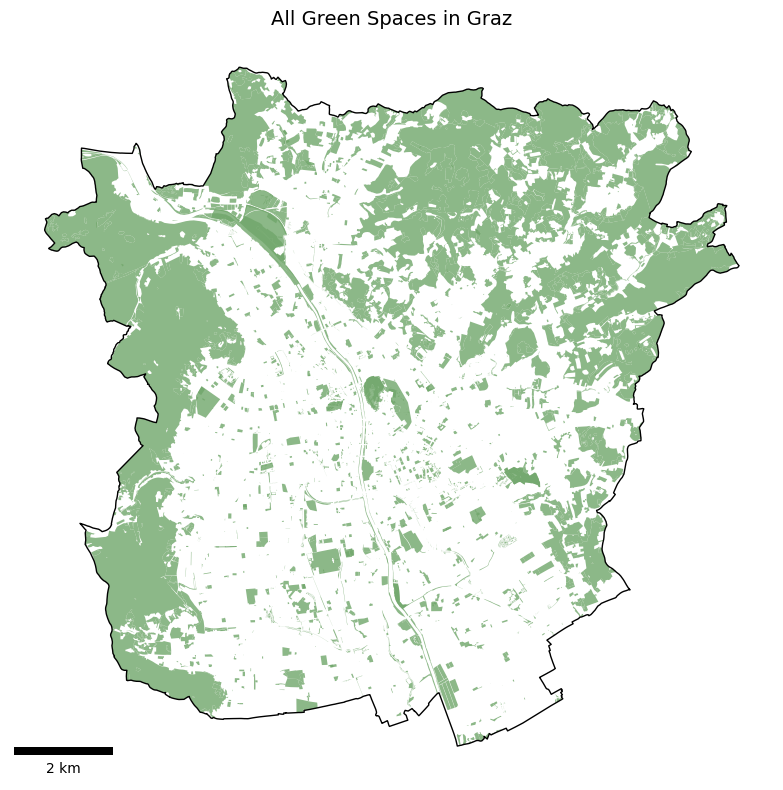

In [124]:
# Map of all green spaces in Graz
fig, ax = plt.subplots(figsize=(10, 8))
green_spaces_graz.plot(ax=ax, color="#70a66a",
                       linewidth=0.3, alpha=0.8)
gdf_graz.boundary.plot(ax=ax, color='black', linewidth=1.0)
ax.set_title('All Green Spaces in Graz', fontsize=14)
ax.axis('off')

# Scale bar in bottom-left
scalebar = ScaleBar(1, units='m', location='lower left', box_alpha=0.6)
ax.add_artist(scalebar)

plt.tight_layout()
plt.show()

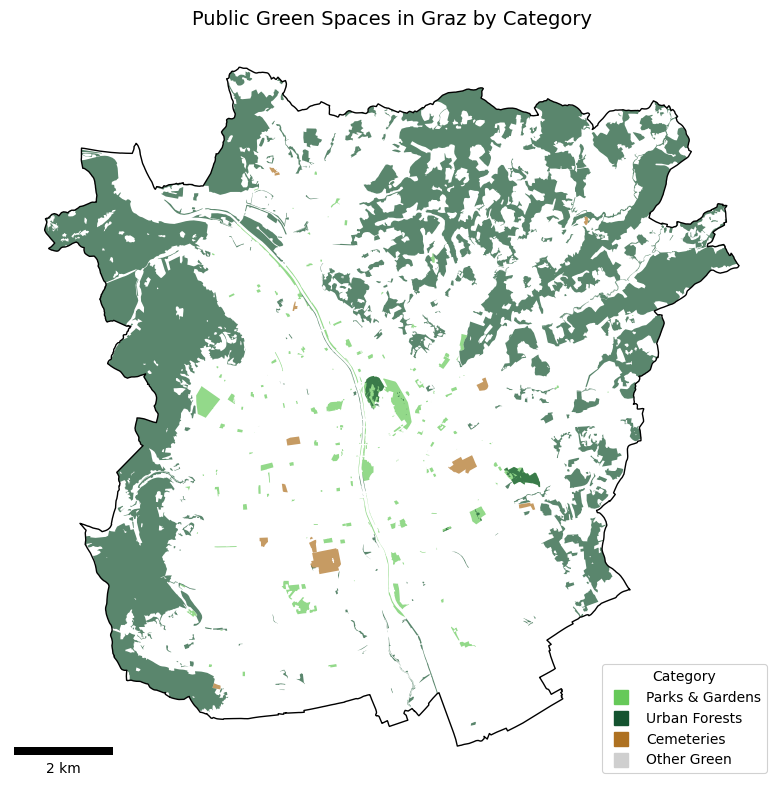

In [125]:
# Map of public green spaces in Graz by category (CLIPPED)

# Clip public_green to Graz boundary
public_green_graz = gpd.clip(public_green, gdf_graz)

# Dissolve by category on the clipped layer
public_green_categories_graz = public_green_graz.dissolve(by='category', as_index=False)

# Define colours
color_map = {
    'park_garden':  "#66c959",   # light green
    'urban_forest': "#14532F",   # dark green
    'cemetery':     "#ae7121",   # brown
    'other':        "#cfcfcf"    # grey
}
colors = public_green_categories_graz['category'].map(color_map)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

public_green_categories_graz.plot(
    ax=ax,
    color=colors,
    edgecolor='none',
    linewidth=0.5,
    alpha=0.7
)
gdf_graz.boundary.plot(ax=ax, color='black', linewidth=1.0)

ax.set_title('Public Green Spaces in Graz by Category', fontsize=14)
ax.axis('off')

# Legend
label_map = {
    'park_garden': 'Parks & Gardens',
    'urban_forest': 'Urban Forests',
    'cemetery':     'Cemeteries',
    'other':        'Other Green'
}
legend_elements = [
    Line2D([0], [0], marker='s', linestyle='', color=color_map[k],
           label=label_map[k], markersize=10)
    for k in color_map.keys()
]
leg = ax.legend(
    handles=legend_elements,
    title='Category',
    loc='lower right',
    frameon=True,
    framealpha=0.9
)
leg.get_frame().set_linewidth(0.8)

# Scale bar
scalebar = ScaleBar(1, units='m', location='lower left',
                    length_fraction=0.25, box_alpha=0.3)
scalebar.font_properties.size = 8
ax.add_artist(scalebar)

plt.tight_layout()
plt.show()


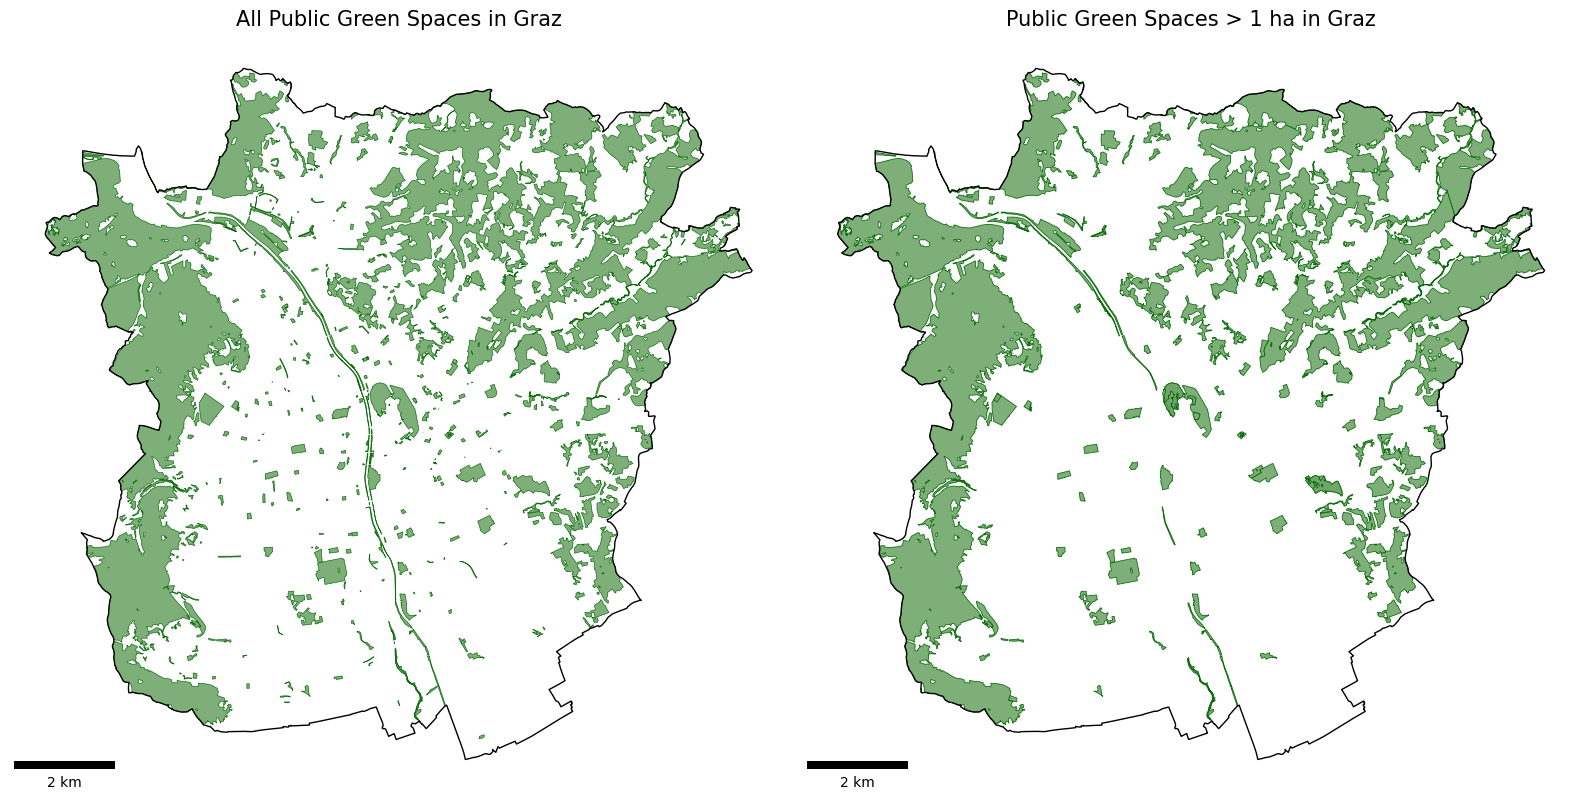

In [126]:
# Map comparing all public green spaces vs. those > 1 ha

# Clip both to Graz
public_green_all_graz = gpd.clip(public_green_all, gdf_graz)
public_green_over_1ha_graz = gpd.clip(public_green_over_1ha, gdf_graz)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Left: all public green
public_green_all_graz.plot(
    ax=axes[0],
    color='#70a66a',
    edgecolor='darkgreen',
    linewidth=0.5,
    alpha=0.9
)
gdf_graz.boundary.plot(ax=axes[0], color='black', linewidth=1.0)
axes[0].set_title('All Public Green Spaces in Graz', fontsize=15)
axes[0].axis('off')

# Right: public green > 1 ha
public_green_over_1ha_graz.plot(
    ax=axes[1],
    color='#70a66a',
    edgecolor='darkgreen',
    linewidth=0.6,
    alpha=0.9
)
gdf_graz.boundary.plot(ax=axes[1], color='black', linewidth=1.0)
axes[1].set_title('Public Green Spaces > 1 ha in Graz', fontsize=15)
axes[1].axis('off')

# Scale bars
for ax in axes:
    scalebar = ScaleBar(1, units='m', location='lower left', box_alpha=0.6)
    scalebar.font_properties.size = 8
    ax.add_artist(scalebar)

plt.tight_layout()
plt.show()


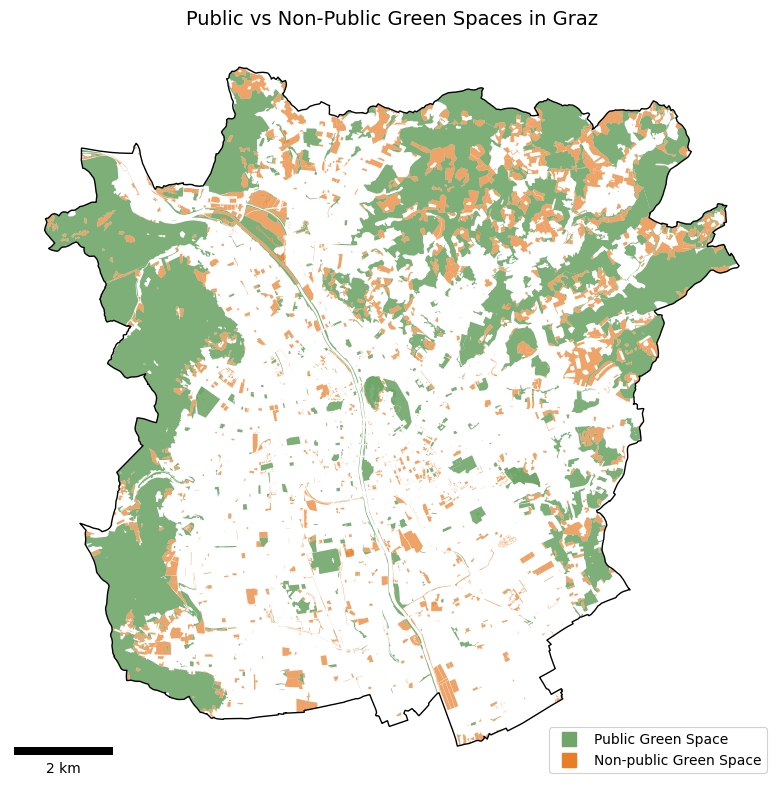

In [127]:
# Map comparing public vs. non-public green spaces in Graz

fig, ax = plt.subplots(figsize=(10, 8))

# Clip inputs to Graz
green_spaces_graz = gpd.clip(green_spaces, gdf_graz)
public_green_graz = gpd.clip(public_green, gdf_graz)

# Keep only polygons / multipolygons
green_spaces_graz = green_spaces_graz[
    green_spaces_graz.geometry.type.isin(['Polygon', 'MultiPolygon'])
]
public_green_graz = public_green_graz[
    public_green_graz.geometry.type.isin(['Polygon', 'MultiPolygon'])
]

# Non‑public green = all green minus public green
non_public_green = gpd.overlay(
    green_spaces_graz,
    public_green_graz,
    how='difference'
)

# Plot polygons
non_public_green.plot(
    ax=ax, color="#e87e28", edgecolor="none",
    alpha=0.7, label='Non‑public green'
)
public_green_graz.plot(
    ax=ax, color="#70a66a", edgecolor='none',
    linewidth=0.4, alpha=0.9, label='Public green'
)
gdf_graz.boundary.plot(ax=ax, color='black', linewidth=1.0)

# Title
ax.set_title('Public vs Non‑Public Green Spaces in Graz', fontsize=14)

# Legend
legend_elements = [
    Line2D([0], [0], marker='s', linestyle='', color="#70a66a",
           label='Public Green Space', markersize=10),
    Line2D([0], [0], marker='s', linestyle='', color="#e87e28",
           label='Non‑public Green Space', markersize=10),
]
leg = ax.legend(handles=legend_elements, loc='lower right',
                frameon=True, framealpha=0.9, title=None)
leg.get_frame().set_linewidth(0.8)

# Scale bar in bottom-left
scalebar = ScaleBar(1, units='m', location='lower left', box_alpha=0.6)
scalebar.font_properties.size = 8
ax.add_artist(scalebar)

# Turn axes off and tidy
ax.axis('off')
plt.tight_layout()
plt.show()


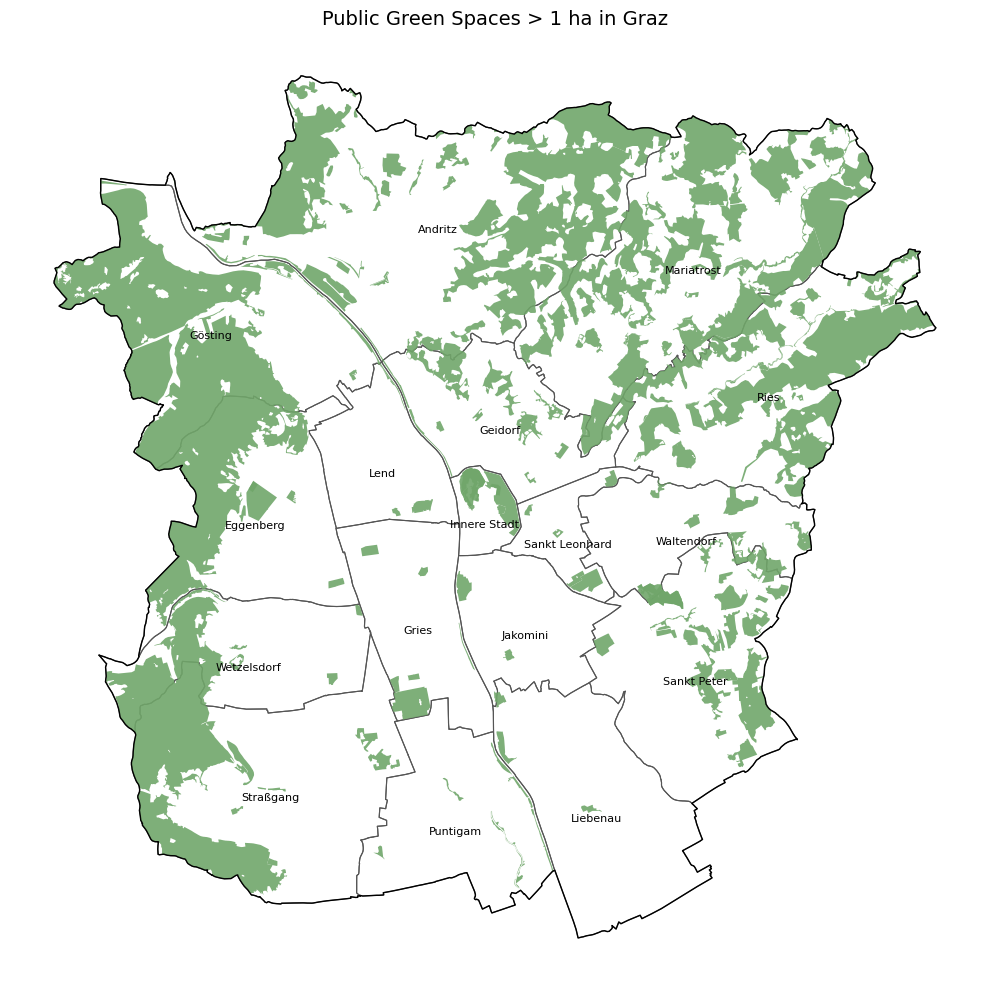

In [128]:
fig, ax = plt.subplots(figsize=(10, 10))

# districts in dark grey
gdf_districts.plot(
    ax=ax,
    facecolor="none",
    edgecolor="#555555",
    linewidth=0.8,
    zorder=1
)

# public green > 1 ha, clipped
public_green_over_1ha_graz = gpd.clip(public_green_over_1ha, gdf_graz)
public_green_over_1ha_graz.plot(
    ax=ax,
    color="#70a66a",
    edgecolor="none",
    linewidth=0.8,
    alpha=0.9,
    zorder=2
)

# Graz boundary
gdf_graz.boundary.plot(
    ax=ax,
    color="black",
    linewidth=1.0,
    zorder=3
)

# District labels (centroids)
for idx, row in gdf_districts.iterrows():
    centroid = row.geometry.centroid
    ax.text(
        centroid.x,
        centroid.y - 200,      # shift 200 m down; adjust value as needed
        row["name"],
        fontsize=8,
        color="black",
        ha="center",
        va="center",
        zorder=4
    )

ax.set_title("Public Green Spaces > 1 ha in Graz", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()


In [129]:
# Calculate the density of parks using Kernel density function
green = green_spaces.copy()
green["centroid"] = green.geometry.centroid
green["area"] = green.geometry.area

xs = green.centroid.x.values
ys = green.centroid.y.values
weights = green.area.values


sns.kdeplot(
    x=xs, y=ys,
    weights=weights,
    bw_adjust=0.5,
    gridsize=100,
    levels=15,
    fill=True,
    cmap="Greens",
    alpha=1,
    thresh=0.01,   # avoid weird artifacts at low density
    ax=ax,
    zorder=0
)

# Make it look nice
ax.set_aspect("equal")
ax.set_title("Greenness Density & Graz District Boundaries", fontsize=14)
ax.set_axis_off()

plt.show()

<Axes: >

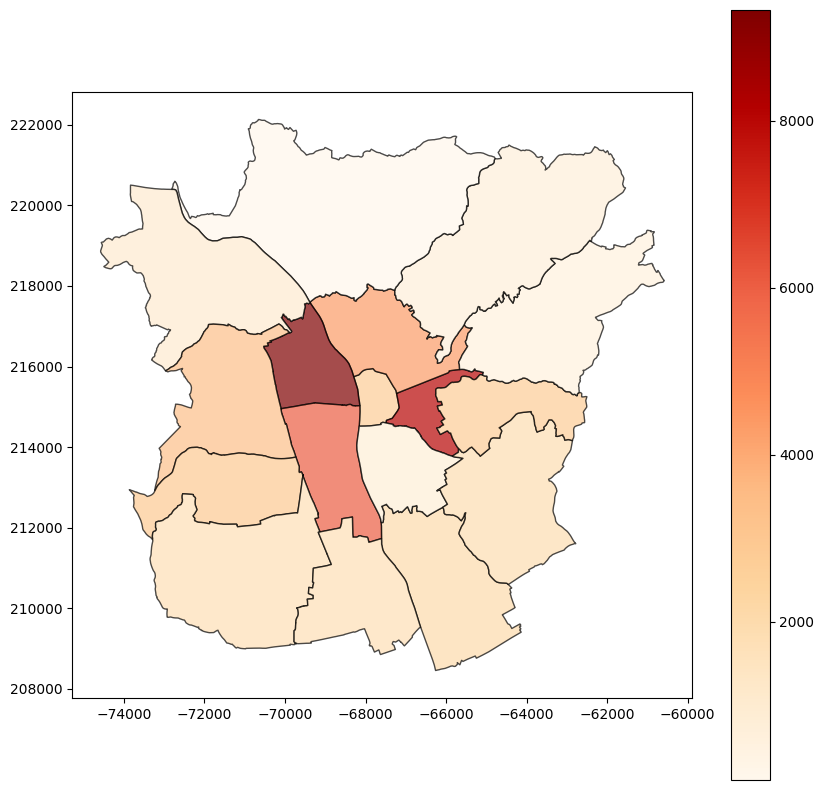

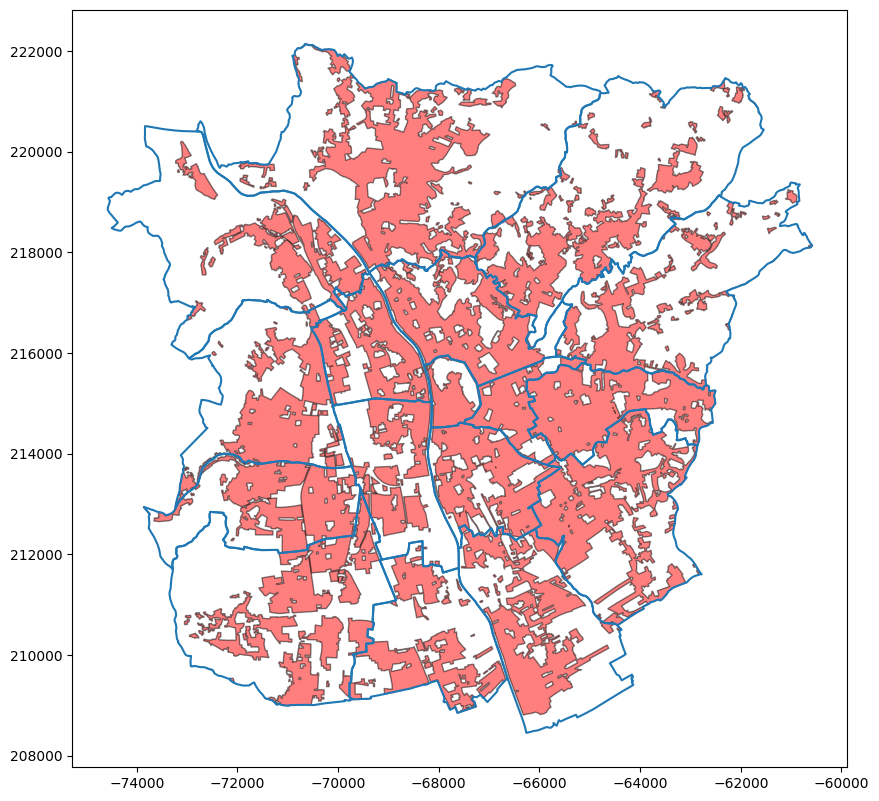

In [130]:
# Population density and residential areas map
gdf_bev_districts.plot(column='Dichte', cmap='OrRd', legend=True, figsize=(10,10), alpha=0.7, edgecolor='k')

gdf_districts.boundary.plot(ax=gdf_residential.plot(figsize=(10,10), alpha=0.5, edgecolor='k', color='red'))

In [131]:
# Map of accessbility to green areas by foot (buffers, green areas and residential areas)

map_euclid = KeplerGl(height=600)
map_euclid.add_data(data=public_green_over_1ha, name='Public Green Spaces')
for d in DISTS:
    map_euclid.add_data(data=eucl_buffers[d], name=f'Buffer {d}m')
map_euclid.add_data(data=eucl_buffers[f'over_{DISTS[-1]}m'], name=f'Buffer over {DISTS[-1]}m')
map_euclid

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


/Users/tarabecker/Uni/GIS_Analyse_Technique2/venv-gst200b/lib/python3.12/site-packages/jupyter_client/session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant: nan
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)
/Users/tarabecker/Uni/GIS_Analyse_Technique2/venv-gst200b/lib/python3.12/site-packages/jupyter_client/session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant: nan
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)
/Users/tarabecker/Uni/GIS_Analyse_Technique2/venv-gst200b/lib/python3.12/site-packages/jupyter_client/session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant: nan
Supporting this message is deprecated in jupyter-client 7, pleas

KeplerGl(data={'Public Green Spaces': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,…

In [132]:
# Map of population density and deficient areas

#gdf_bev_districts      #population density by district
#deficient_area_eucl    #residential areas not within certain distance of green space


In [133]:
# Choropleth map of deficient area percentage within each district
# deficient_areas_districts 

#### Green Space Accessibility Zones (Walking Distance)

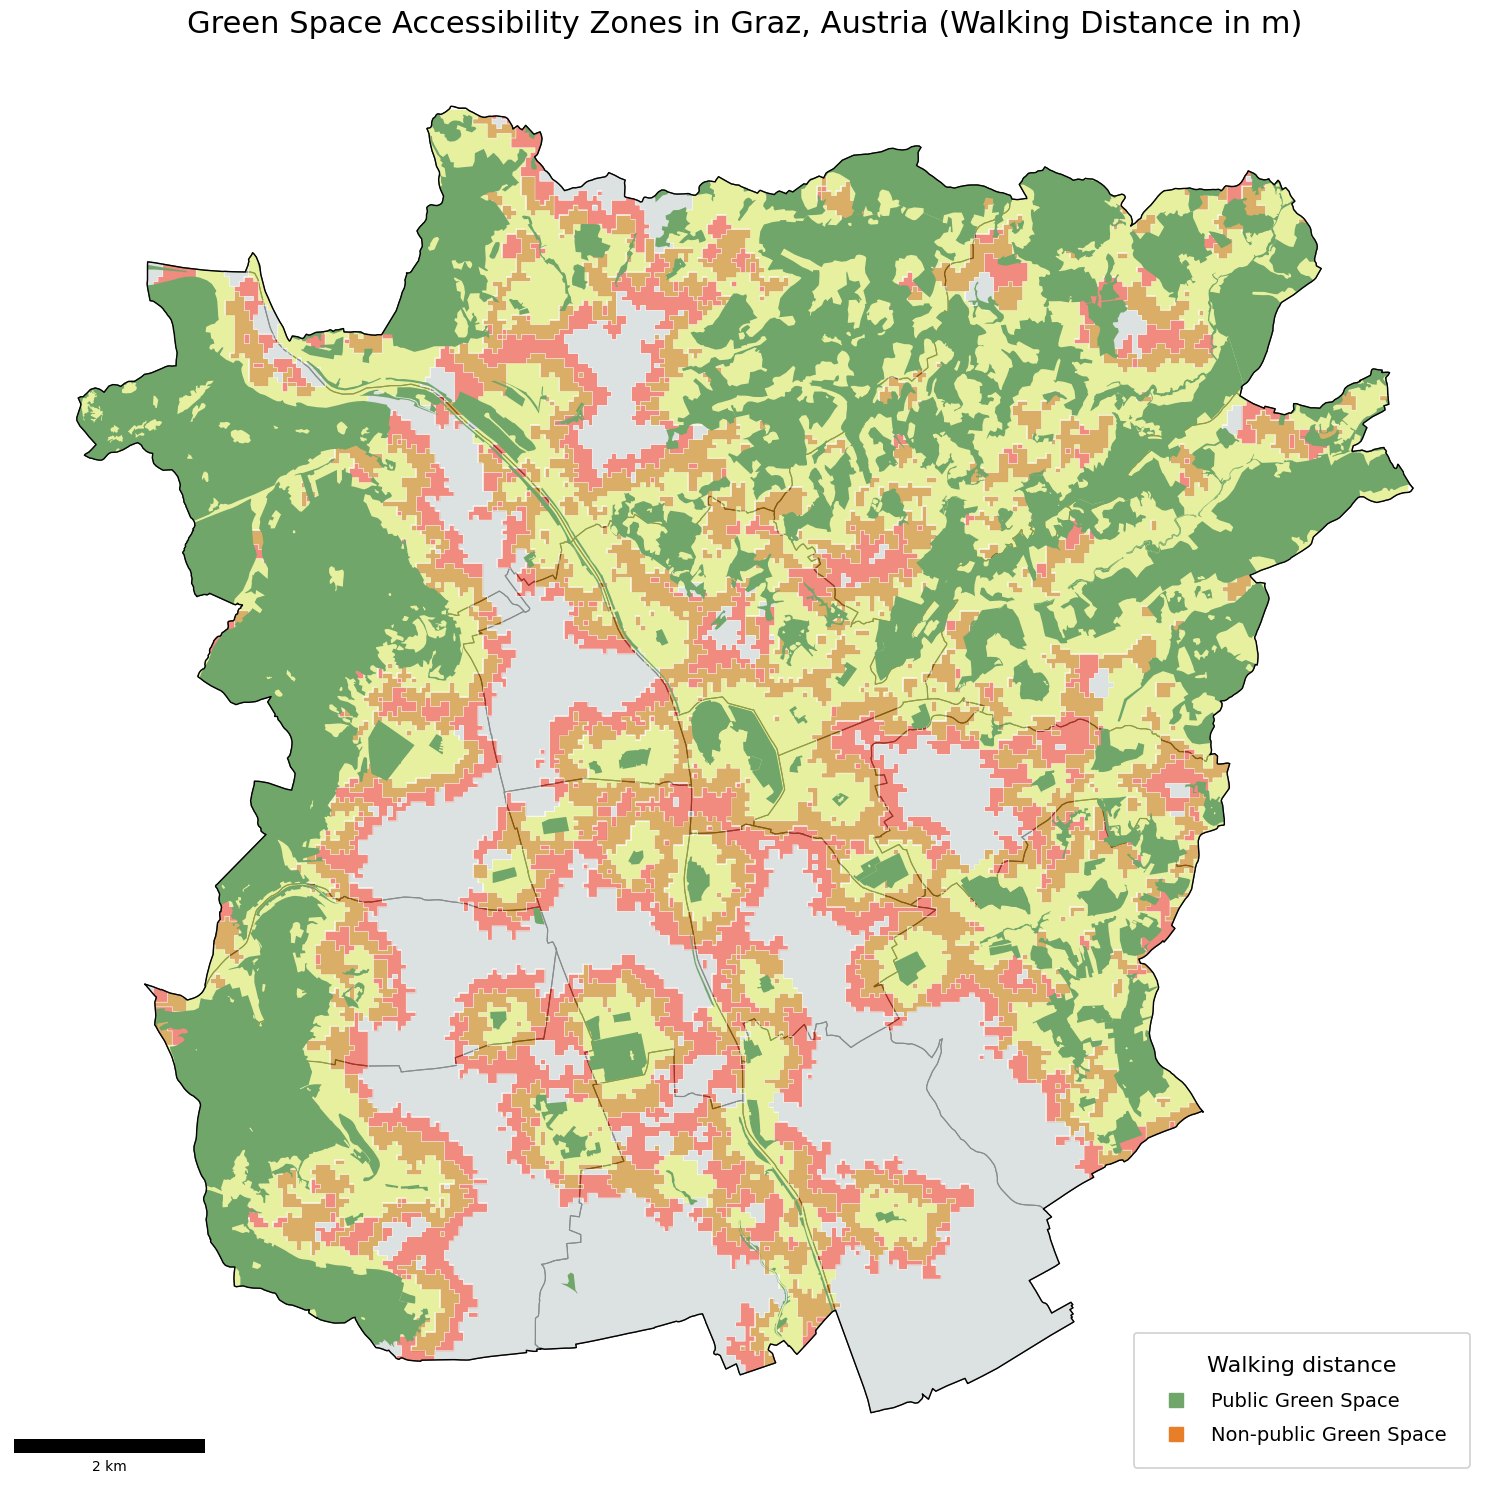

In [134]:
# Map of accessbility zones of Green Spaces in Graz

fig, ax = plt.subplots(figsize=(15, 15))

# District boundaries in grey
gdf_districts.plot(
    ax=ax,
    facecolor="none",
    edgecolor="#292929",   # dark grey
    linewidth=0.8,
    zorder=0
)

# Plot zones
for idx, row in zones_gdf.iterrows():
    gpd.GeoSeries([row.geometry]).plot(
        ax=ax,
        color=row['color'],
        alpha=0.6,
        edgecolor='white',
        linewidth=0.5,
        zorder=1
    )

# Green spaces on top
public_green_over_1ha.plot(
    ax=ax, color='#70a66a', alpha=1, edgecolor='none',
    label='Public green > 1 ha', zorder=2
)

# Graz boundary in black
gdf_graz.boundary.plot(ax=ax, color='black', linewidth=1.0, zorder=3)

ax.set_title('Green Space Accessibility Zones in Graz, Austria (Walking Distance in m)', fontsize=22)
ax.axis('off')

# Legend
leg = ax.legend(
    handles=legend_elements,
    title='Walking distance',
    loc='lower right',
    frameon=True,
    framealpha=0.9,
    fontsize=14,
    title_fontsize=16,
    borderpad=1.2,
    labelspacing=0.8
)
frame = leg.get_frame()
frame.set_linewidth(1.2)

# 2 km scale bar in bottom-left (CRS is metric EPSG:31256)
scalebar = ScaleBar(1, units='m', location='lower left',
                    length_fraction=0.25, box_alpha=0.3)
scalebar.font_properties.size = 10
ax.add_artist(scalebar)

plt.tight_layout()
plt.show()
